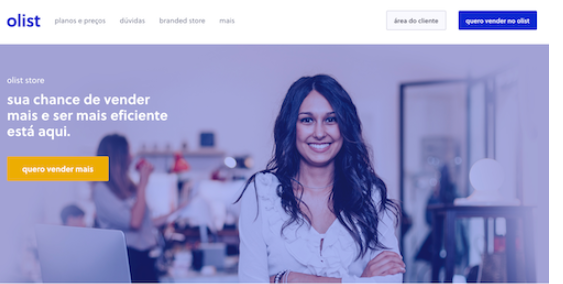

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import datetime as dt
from sklearn.cluster import KMeans
from sklearn import preprocessing, cluster, metrics, decomposition
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('olist_dataset.csv')

In [3]:
df.head()

order_id    order_approved_at  temps_session  \
0  e481f51cbdc54678b7cc49136f2d6af7  2017-10-02 11:07:15          642.0   
1  e481f51cbdc54678b7cc49136f2d6af7  2017-10-02 11:07:15          642.0   
2  e481f51cbdc54678b7cc49136f2d6af7  2017-10-02 11:07:15          642.0   
3  53cdb2fc8bc7dce0b6741e2150273451  2018-07-26 03:24:27       110570.0   
4  47770eb9100c2d0c44946d9cf07ec65d  2018-08-08 08:55:23          994.0   

   experience_client  temps_livraison_estime  review_score  temps_de_reponse  \
0           728920.0               1342365.0           4.0          1.155417   
1           728920.0               1342365.0           4.0          1.155417   
2           728920.0               1342365.0           4.0          1.155417   
3          1190768.0               1542933.0           4.0          0.776273   
4           811660.0               2300677.0           5.0          4.797199   

   longueur_comment_message  payment_type  payment_value  ... audio  drinks  \
0                     170.0             1          18.12  ...     0       0   
1                     170.0             3           2.00  ...     0       0   
2                     170.0             3          18.59  ...     0       0   
3                      20.0             0         141.46  ...     0       0   
4                       1.0             1         179.12  ...     0       0   

   market_place  construction_tools_lights  \
0             0                          0   
1             0                          0   
2             0                          0   
3             0                          0   
4             0                          0   

   kitchen_dining_laundry_garden_furniture  air_conditioning food_drink  \
0                                        0                 0          0   
1                                        0                 0          0   
2                                        0                 0          0   
3                                        0                 0          0   
4                                        0                 0          0   

   fashion_shoes  industry_commerce_and_business  books_technical  
0              0                               0                0  
1              0                               0                0  
2              0                               0                0  
3              0                               0                0  
4              0                               0                0  

[5 rows x 57 columns]

# RFM (Recency, Frequency, Monetary)

* Récence (Recency) : Il s'agit du temps écoulé depuis la dernière transaction d'un client. Cette valeur mesure la fidélité du client et son activité récente.


* Fréquence (Frequency) : Il s'agit du nombre de transactions effectuées par un client au cours d'une période donnée. Cette valeur mesure la fidélité du client et son engagement.


* Montant (Monetary) : Il s'agit de la valeur totale des transactions effectuées par un client au cours d'une période donnée. Cette valeur mesure la valeur que le client représente pour l'entreprise.

In [4]:
# Make the date_placed column datetime
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])

In [5]:
NOW = dt.datetime(2018, 12, 31)

In [6]:
rfm = df.groupby('customer_unique_id').agg({'order_approved_at': lambda x: (NOW - x.max()).days, # Recency
                                        'order_item_id': lambda x: len(x),      # Frequency
                                        'payment_value': lambda x: x.sum()}) # Monetary Value

In [7]:
rfm['order_approved_at'] = rfm['order_approved_at'].astype(int)

In [8]:
rfm.rename(columns={'order_approved_at': 'recency',
                    'order_item_id': 'frequency',
                    'payment_value': 'monetary_value'}, inplace=True)

## RFM Quartiles

In [9]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])

In [10]:
quantiles

recency  frequency  monetary_value
0.25    236.0        1.0          63.660
0.50    340.0        1.0         112.840
0.75    467.0        1.0         202.605

In [11]:
quantiles = quantiles.to_dict()

In [12]:
quantiles

{'recency': {0.25: 236.0, 0.5: 340.0, 0.75: 467.0},
 'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'monetary_value': {0.25: 63.66, 0.5: 112.84, 0.75: 202.60500000000002}}

## RFM Segmentation

In [13]:
rfmSegmentation = rfm.copy()

In [14]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [15]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))

In [16]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [17]:
rfmSegmentation

recency  frequency  monetary_value  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2      234        1.0          141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f      237        1.0           27.19   
0000f46a3911fa3c0805444483337064      660        1.0           86.22   
0000f6ccb0745a6a4b88665a16c9f078      444        1.0           43.62   
0004aac84e0df4da2b147fca70cf8255      411        1.0          196.89   
...                                   ...        ...             ...   
fffcf5a5ff07b0908bd4e2dbc735a684      570        2.0         4134.84   
fffea47cd6d3cc0a88bd621562a9d061      385        1.0           84.58   
ffff371b4d645b6ecea244b27531430a      691        1.0          112.46   
ffff5962728ec6157033ef9805bacc48      242        1.0          133.69   
ffffd2657e2aad2907e67c3e9daecbeb      606        1.0           71.56   

                                  R_Quartile  F_Quartile  M_Quartile RFMClass  
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2           1           4           2      142  
0000b849f77a49e4a4ce2b2a4ca5be3f           2           4           4      244  
0000f46a3911fa3c0805444483337064           4           4           3      443  
0000f6ccb0745a6a4b88665a16c9f078           3           4           4      344  
0004aac84e0df4da2b147fca70cf8255           3           4           2      342  
...                                      ...         ...         ...      ...  
fffcf5a5ff07b0908bd4e2dbc735a684           4           1           1      411  
fffea47cd6d3cc0a88bd621562a9d061           3           4           3      343  
ffff371b4d645b6ecea244b27531430a           4           4           3      443  
ffff5962728ec6157033ef9805bacc48           2           4           2      242  
ffffd2657e2aad2907e67c3e9daecbeb           4           4           3      443  

[91074 rows x 7 columns]

In [18]:
rfmSegmentation[rfmSegmentation['RFMClass']=='111'].sort_values('monetary_value', ascending=False).head(5)

recency  frequency  monetary_value  \
customer_unique_id                                                     
adfa1cab2b2c8706db21bb13c0a1beb1      212        6.0        19457.04   
1b76903617af13189607a36b0469f6f3      221        6.0        19174.38   
fff5eb4918b2bf4b2da476788d42051c      178        6.0        17069.76   
be825ddd3b40db3f91bf05b4e9435d56      201        4.0        12490.88   
906a8a4ec9f3d4c3e64fa6d1c4fe6009      162        7.0        11881.01   

                                  R_Quartile  F_Quartile  M_Quartile RFMClass  
customer_unique_id                                                             
adfa1cab2b2c8706db21bb13c0a1beb1           1           1           1      111  
1b76903617af13189607a36b0469f6f3           1           1           1      111  
fff5eb4918b2bf4b2da476788d42051c           1           1           1      111  
be825ddd3b40db3f91bf05b4e9435d56           1           1           1      111  
906a8a4ec9f3d4c3e64fa6d1c4fe6009           1           1           1      111

Les clients ayant la meilleure récense, fréquence et valeur

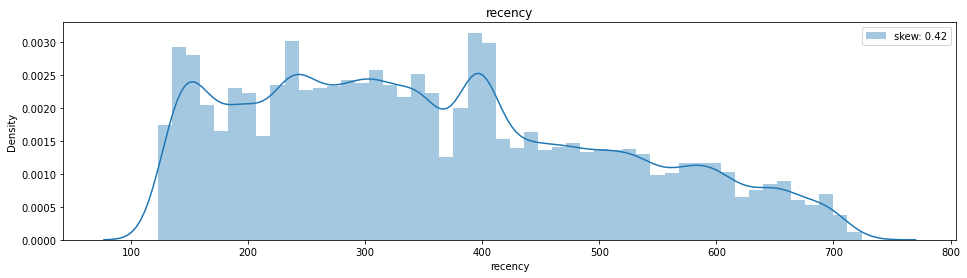

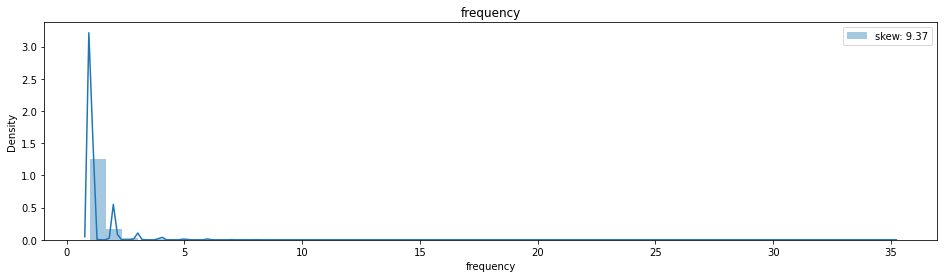

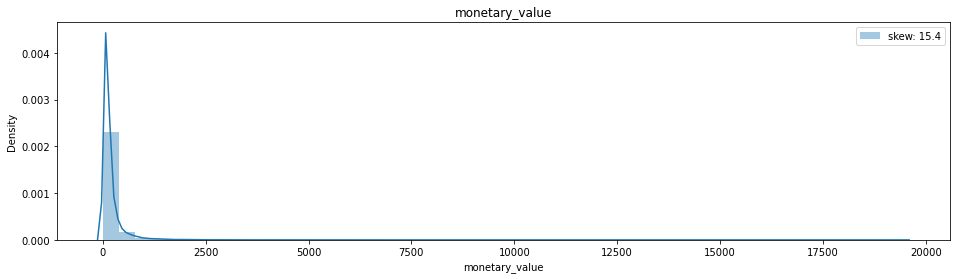

In [19]:
# réprésentation avec un displot 
for col in rfm:
    plt.figure(figsize=(16, 4))
    sns.distplot(rfm[col], label="skew: "+str(np.round(rfm[col].skew(),2)))
    plt.title(col)
    plt.legend()

In [20]:
import scipy.stats as st
import statsmodels.api as sm

In [21]:
for col in rfm:
        w, pvalue = st.shapiro(rfm[col])
        seuil = 0.05
        print(f'{col :-<50} {w} {pvalue}')
        if pvalue > seuil:
            print(
                "On ne peux pas rejetter H0: la distribution suit une loi normale")
        else:
            print(
                "On rejette H0 : la distribution ne suit pas une loi normale")

recency------------------------------------------- 0.9597442746162415 0.0
On rejette H0 : la distribution ne suit pas une loi normale
frequency----------------------------------------- 0.3187635540962219 0.0
On rejette H0 : la distribution ne suit pas une loi normale
monetary_value------------------------------------ 0.303963840007782 0.0
On rejette H0 : la distribution ne suit pas une loi normale


recency


<Figure size 432x288 with 0 Axes>

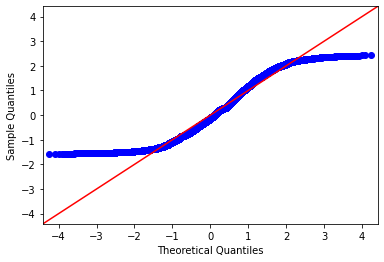

frequency


<Figure size 432x288 with 0 Axes>

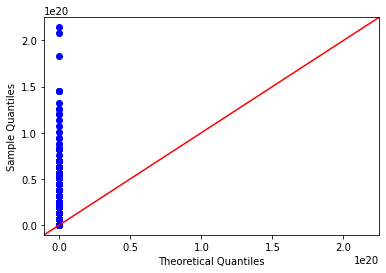

monetary_value


<Figure size 432x288 with 0 Axes>

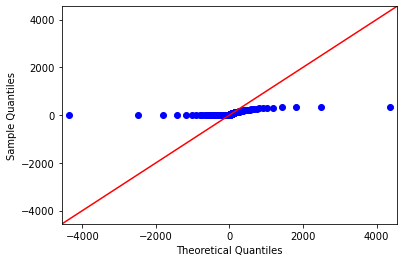

In [22]:
# qqpolot vs. loi normale (droite de Henry)
for col in rfm:
    plt.figure()
    sm.qqplot(rfm[col], st.t, fit=True, line="45")
    print(col)
    plt.show()

# Corrélation

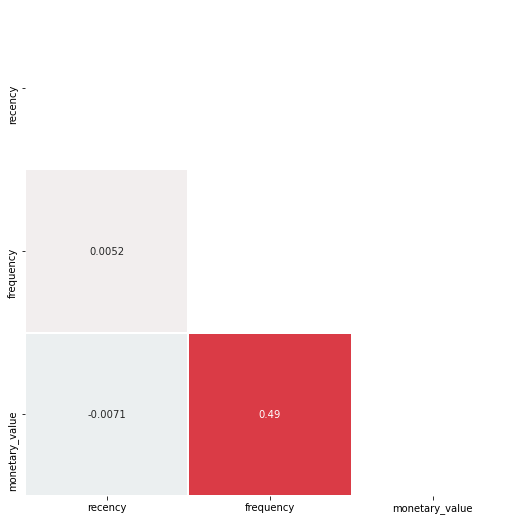

In [23]:
# Compute the correlation matrix
corr = rfm.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig = sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
                  square=True, linewidths=.5, cbar=None)

# Normalisation

In [24]:
rfm = rfm.reset_index()

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
rfm_transform = rfm.copy()

In [27]:
scaler = StandardScaler()

In [28]:
cols_to_scale = ['recency', 'frequency', 'monetary_value']

In [29]:
def scaleColumns(rfm_transform, cols_to_scale):
    for col in cols_to_scale:
        rfm_transform[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(rfm_transform[col])),columns=[col])
    return rfm_transform

In [30]:
rfm_scaled = scaleColumns(rfm_transform, cols_to_scale)
rfm_scaled

customer_unique_id   recency  frequency  monetary_value
0      0000366f3b9a7992bf8c76cfdf3221e2 -0.824816  -0.301230       -0.151566
1      0000b849f77a49e4a4ce2b2a4ca5be3f -0.804923  -0.301230       -0.411915
2      0000f46a3911fa3c0805444483337064  1.999912  -0.301230       -0.277939
3      0000f6ccb0745a6a4b88665a16c9f078  0.567656  -0.301230       -0.374625
4      0004aac84e0df4da2b147fca70cf8255  0.348839  -0.301230       -0.026759
...                                 ...       ...        ...             ...
91069  fffcf5a5ff07b0908bd4e2dbc735a684  1.403139   1.006343        8.910946
91070  fffea47cd6d3cc0a88bd621562a9d061  0.176438  -0.301230       -0.281661
91071  ffff371b4d645b6ecea244b27531430a  2.205467  -0.301230       -0.218384
91072  ffff5962728ec6157033ef9805bacc48 -0.771769  -0.301230       -0.170199
91073  ffffd2657e2aad2907e67c3e9daecbeb  1.641848  -0.301230       -0.311212

[91074 rows x 4 columns]

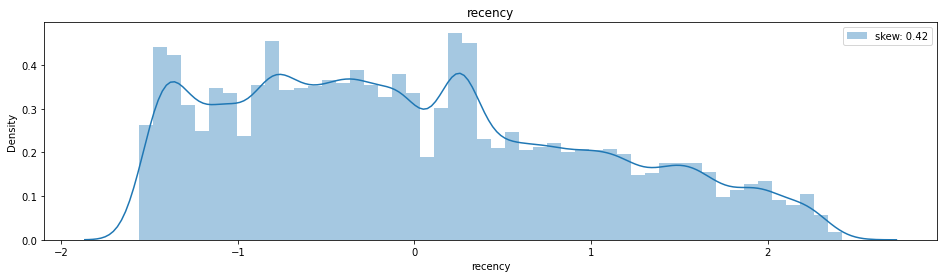

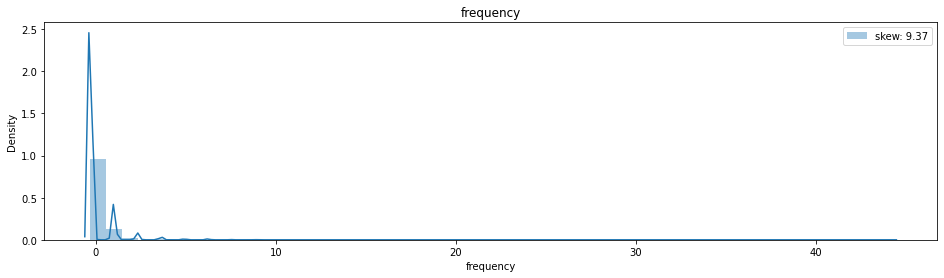

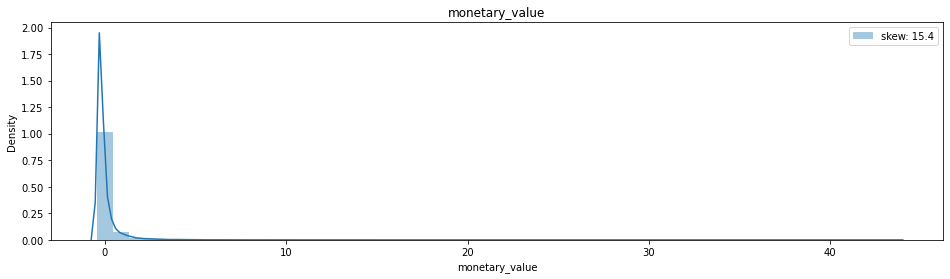

In [31]:
# réprésentation avec un displot de la normalisation
for col in cols_to_scale:
    plt.figure(figsize=(16, 4))
    sns.distplot(rfm_scaled[col], label="skew: "+str(np.round(rfm_scaled[col].skew(),2)))
    plt.title(col)
    plt.legend()

In [32]:
for col in cols_to_scale:
        w, pvalue = st.shapiro(rfm_scaled[col])
        seuil = 0.05
        print(f'{col :-<50} {w} {pvalue}')
        if pvalue > seuil:
            print(
                "On ne peux pas rejetter H0: la distribution suit une loi normale")
        else:
            print(
                "On rejette H0 : la distribution ne suit pas une loi normale")

recency------------------------------------------- 0.9597419500350952 0.0
On rejette H0 : la distribution ne suit pas une loi normale
frequency----------------------------------------- 0.31875282526016235 0.0
On rejette H0 : la distribution ne suit pas une loi normale
monetary_value------------------------------------ 0.3039640188217163 0.0
On rejette H0 : la distribution ne suit pas une loi normale


recency


<Figure size 432x288 with 0 Axes>

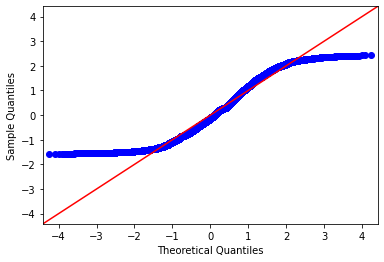

frequency


<Figure size 432x288 with 0 Axes>

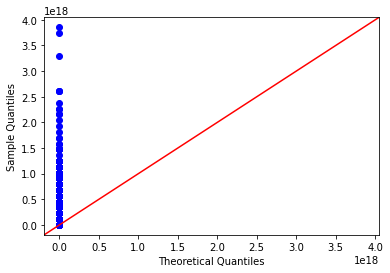

monetary_value


<Figure size 432x288 with 0 Axes>

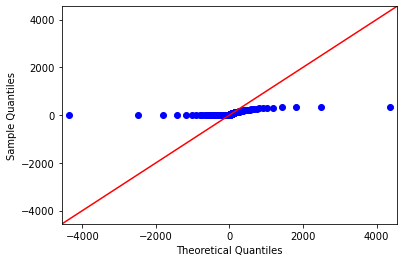

In [33]:
# qqpolot vs. loi normale (droite de Henry)
for col in cols_to_scale:
    plt.figure()
    sm.qqplot(rfm_scaled[col], st.t, fit=True, line="45")
    print(col)
    plt.show()

In [34]:
df_kmeans = rfm_scaled.copy()

In [35]:
df_kmeans = df_kmeans.set_index('customer_unique_id')

In [36]:
# Données
X_kmeans = df_kmeans.select_dtypes('number')

#  Kmeans Clustering
## Kmeans RFM (3 variables)

In [37]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=0).fit(X_kmeans)
                for k in range(1, 15)]
inertias = [model.inertia_ for model in kmeans_per_k]

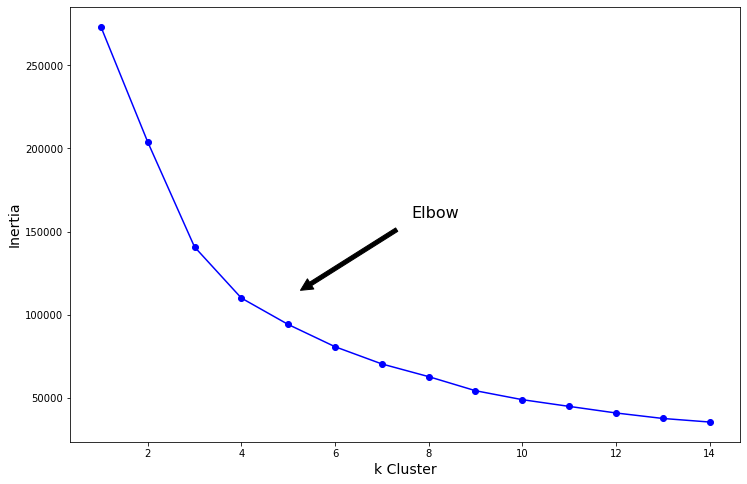

In [38]:
# plot inertia as a function of k and analyze the resulting curve.
plt.figure(figsize=(12, 8))
plt.plot(range(1, 15), inertias, 'bo-')
plt.xlabel('k Cluster', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.annotate('Elbow',
             xy=(5, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords="figure fraction",
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1))

plt.show()

In [39]:
k = 4
kmeans = KMeans(n_clusters=k,random_state=0).fit(X_kmeans)

In [40]:
df_kmeans['Kmeans_cluster'] = kmeans.labels_

In [41]:
df_kmeans.head()

recency  frequency  monetary_value  \
customer_unique_id                                                      
0000366f3b9a7992bf8c76cfdf3221e2 -0.824816   -0.30123       -0.151566   
0000b849f77a49e4a4ce2b2a4ca5be3f -0.804923   -0.30123       -0.411915   
0000f46a3911fa3c0805444483337064  1.999912   -0.30123       -0.277939   
0000f6ccb0745a6a4b88665a16c9f078  0.567656   -0.30123       -0.374625   
0004aac84e0df4da2b147fca70cf8255  0.348839   -0.30123       -0.026759   

                                  Kmeans_cluster  
customer_unique_id                                
0000366f3b9a7992bf8c76cfdf3221e2               1  
0000b849f77a49e4a4ce2b2a4ca5be3f               1  
0000f46a3911fa3c0805444483337064               3  
0000f6ccb0745a6a4b88665a16c9f078               3  
0004aac84e0df4da2b147fca70cf8255               3

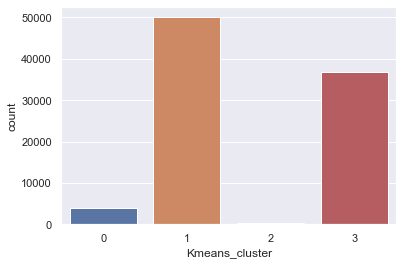

In [42]:
# repartition nb de pays /cluster
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Kmeans_cluster", data=df_kmeans)

In [43]:
# les moyennes des groupes Kmeans par feature
df_kmeans_gb = df_kmeans.groupby(["Kmeans_cluster"]).mean()
df_kmeans_gb

recency  frequency  monetary_value
Kmeans_cluster                                     
0              -0.035896   3.016412        1.628741
1              -0.723080  -0.156861       -0.105939
2              -0.049670   8.046166       13.592362
3               0.984330  -0.150199       -0.105150

In [44]:
rfm 

customer_unique_id  recency  frequency  monetary_value
0      0000366f3b9a7992bf8c76cfdf3221e2      234        1.0          141.90
1      0000b849f77a49e4a4ce2b2a4ca5be3f      237        1.0           27.19
2      0000f46a3911fa3c0805444483337064      660        1.0           86.22
3      0000f6ccb0745a6a4b88665a16c9f078      444        1.0           43.62
4      0004aac84e0df4da2b147fca70cf8255      411        1.0          196.89
...                                 ...      ...        ...             ...
91069  fffcf5a5ff07b0908bd4e2dbc735a684      570        2.0         4134.84
91070  fffea47cd6d3cc0a88bd621562a9d061      385        1.0           84.58
91071  ffff371b4d645b6ecea244b27531430a      691        1.0          112.46
91072  ffff5962728ec6157033ef9805bacc48      242        1.0          133.69
91073  ffffd2657e2aad2907e67c3e9daecbeb      606        1.0           71.56

[91074 rows x 4 columns]

In [45]:
df_kmeans_real_val = pd.merge(rfm,df_kmeans['Kmeans_cluster'], on="customer_unique_id")

In [46]:
df_kmeans_real_val

customer_unique_id  recency  frequency  monetary_value  \
0      0000366f3b9a7992bf8c76cfdf3221e2      234        1.0          141.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f      237        1.0           27.19   
2      0000f46a3911fa3c0805444483337064      660        1.0           86.22   
3      0000f6ccb0745a6a4b88665a16c9f078      444        1.0           43.62   
4      0004aac84e0df4da2b147fca70cf8255      411        1.0          196.89   
...                                 ...      ...        ...             ...   
91069  fffcf5a5ff07b0908bd4e2dbc735a684      570        2.0         4134.84   
91070  fffea47cd6d3cc0a88bd621562a9d061      385        1.0           84.58   
91071  ffff371b4d645b6ecea244b27531430a      691        1.0          112.46   
91072  ffff5962728ec6157033ef9805bacc48      242        1.0          133.69   
91073  ffffd2657e2aad2907e67c3e9daecbeb      606        1.0           71.56   

       Kmeans_cluster  
0                   1  
1                   1  
2                   3  
3                   3  
4                   3  
...               ...  
91069               0  
91070               3  
91071               3  
91072               1  
91073               3  

[91074 rows x 5 columns]

In [47]:
# les moyennes des groupes Kmeans par feature
df_kmeans_real_val_gb = df_kmeans_real_val.groupby(["Kmeans_cluster"]).mean()
df_kmeans_real_val_gb

recency  frequency  monetary_value
Kmeans_cluster                                       
0               352.977829   3.537252      926.302503
1               249.342835   1.110410      162.003128
2               350.900474   7.383886     6197.470521
3               506.839079   1.115504      162.350692

<AxesSubplot:ylabel='Kmeans_cluster'>

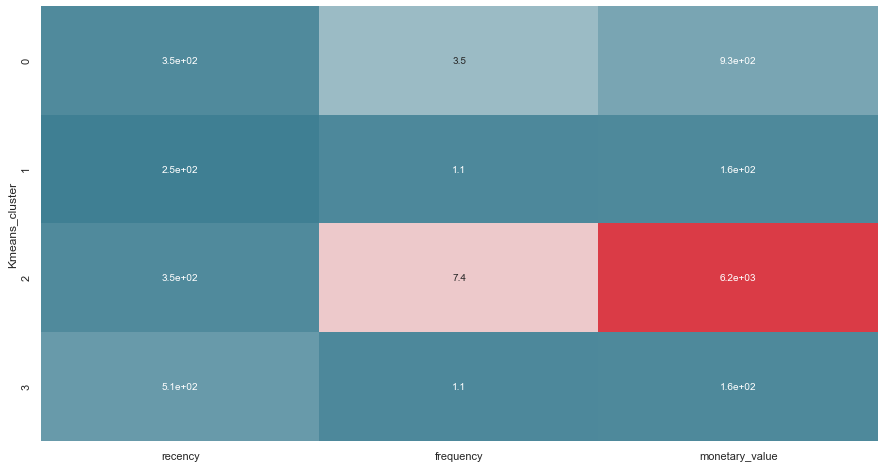

In [48]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_kmeans_gb, cmap=cmap, annot=df_kmeans_real_val_gb,
            annot_kws={'size': 10}, cbar=None)

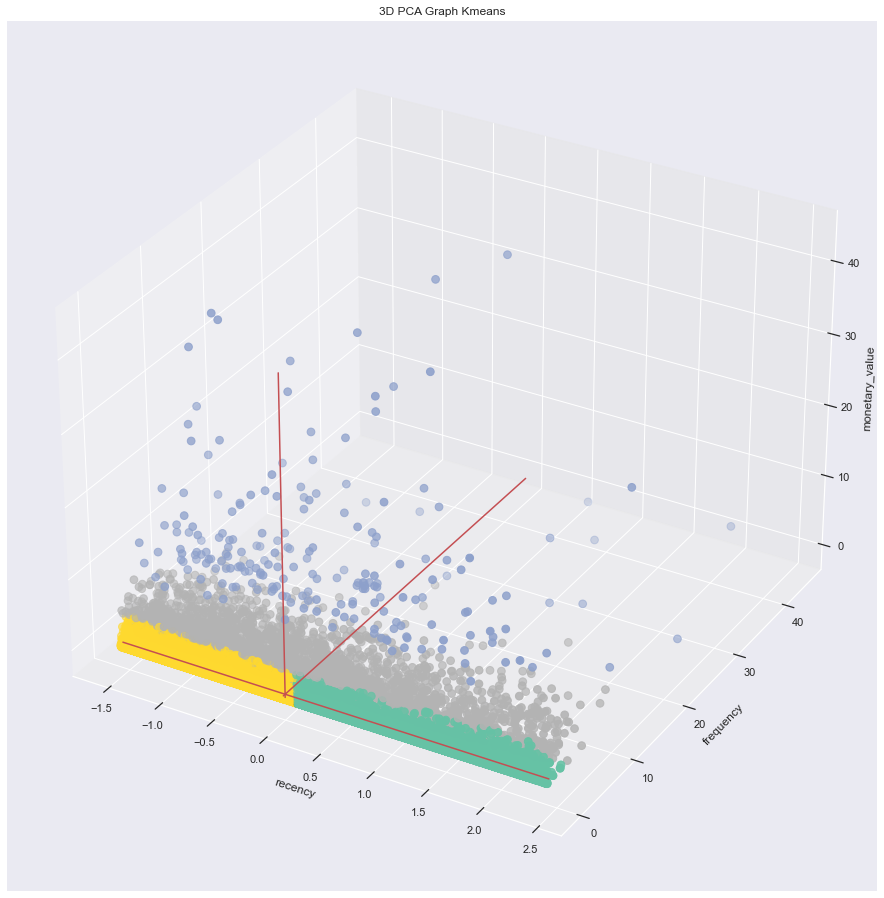

In [49]:
my_color = df_kmeans['Kmeans_cluster']


# Plot initialisation
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_kmeans['recency'], df_kmeans['frequency'],
           df_kmeans['monetary_value'], c=my_color, cmap="Set2_r", s=60)

# make simple, bare axis lines through space:
xAxisLine = ((min(df_kmeans['recency']), max(
    df_kmeans['recency'])), (0, 0), (0, 0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(df_kmeans['frequency']), max(
    df_kmeans['frequency'])), (0, 0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0, 0),
             (min(df_kmeans['monetary_value']), max(df_kmeans['monetary_value'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')


# label the axes
ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("monetary_value")
ax.set_title("3D PCA Graph Kmeans")
plt.show()

## Kmeans Recense / Frequence

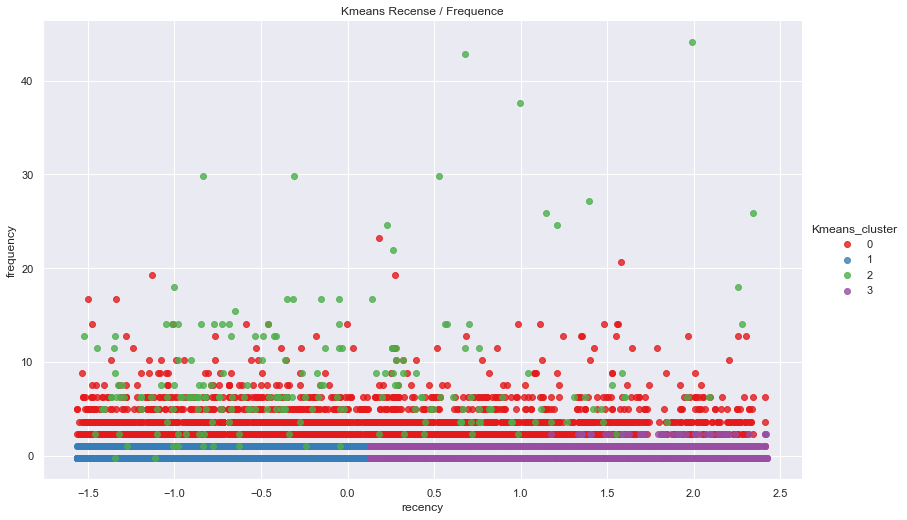

In [50]:
sns.set()
sns.lmplot(
    x='recency',
    y='frequency',
    data=df_kmeans,
    hue='Kmeans_cluster',
    fit_reg=False,
    legend=True,
    palette="Set1",
    height=7, aspect=1.6)

plt.title('Kmeans Recense / Frequence')
plt.show()

## Kmeans Recense / Montant

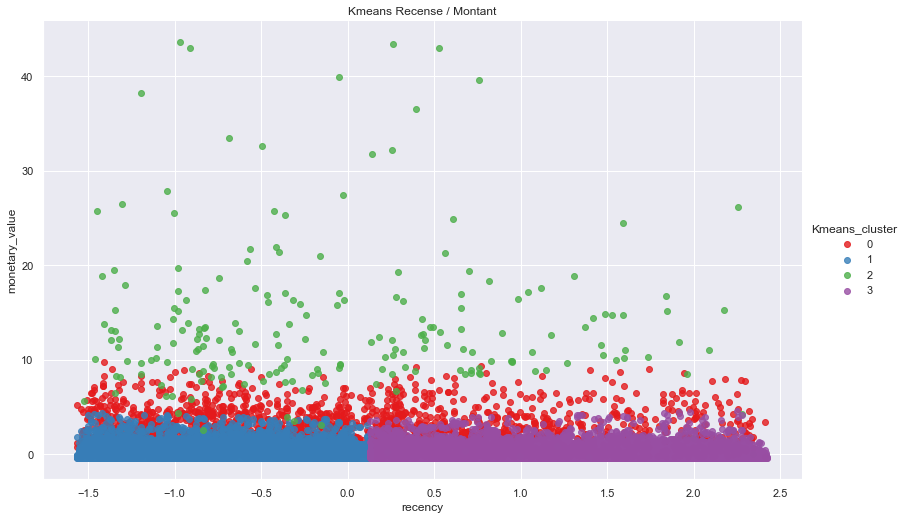

In [51]:
sns.set()
sns.lmplot(
    x='recency',
    y='monetary_value',
    data=df_kmeans,
    hue='Kmeans_cluster',
    fit_reg=False,
    legend=True,
    palette="Set1",
    height=7, aspect=1.6)

plt.title('Kmeans Recense / Montant')
plt.show()

## Kmeans Frequence / Montant

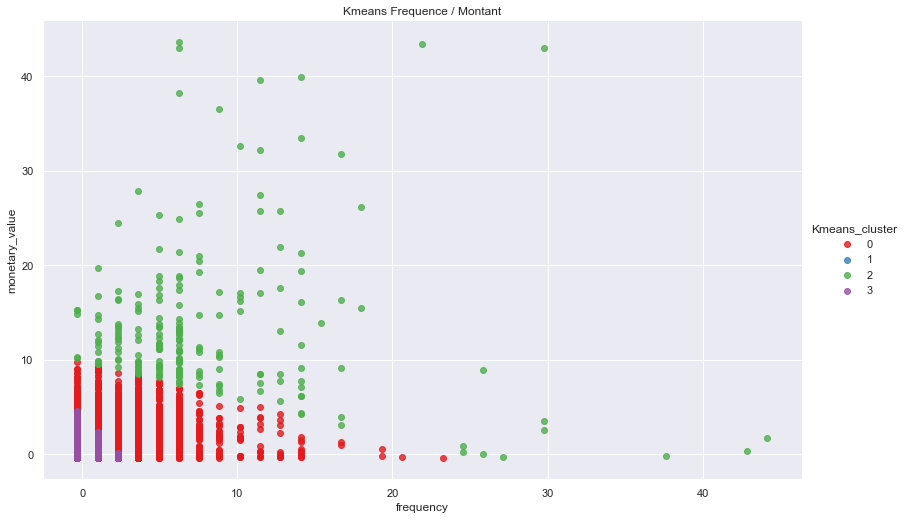

In [52]:
sns.set()
sns.lmplot(
    x='frequency',
    y='monetary_value',
    data=df_kmeans,
    hue='Kmeans_cluster',
    fit_reg=False,
    legend=True,
    palette="Set1",
    height=7, aspect=1.6)

plt.title('Kmeans Frequence / Montant')
plt.show()

# Classification ascendante hiérarchique (CAH)

In [53]:
df_CAH = rfm_scaled.copy()

In [54]:
df_CAH = df_CAH.set_index('customer_unique_id')

In [55]:
# Définition du nombre de lots
batch_size = 10000

# Définition du nombre de clusters
n_clusters = 5

# Initialisation de l'agglomérative clustering
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Boucle pour traiter les données par lots
for i in range(0, df_CAH.shape[0], batch_size):
    batch = df_CAH.iloc[i:i + batch_size, :]
    batch_labels = agg_clustering.fit_predict(batch)
    if i == 0:
        labels = batch_labels
    else:
        labels = np.concatenate([labels, batch_labels])

# Ajout des étiquettes au jeu de données
df_CAH["CAH_cluster"] = labels

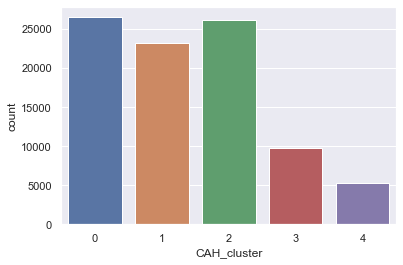

In [56]:
# repartition nb de CLIENTS /cluster
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="CAH_cluster", data=df_CAH)

In [57]:
# les moyennes des groupes Kmeans par feature
df_CAH_gb = df_CAH.groupby(["CAH_cluster"]).mean()
df_CAH_gb

recency  frequency  monetary_value
CAH_cluster                                     
0           -0.307778   0.096095        0.048565
1            0.332883   0.008845       -0.007626
2            0.403509  -0.092032       -0.086660
3           -0.674348  -0.185581        0.012086
4           -0.657216   0.275749        0.193981

In [58]:
df_CAH_real_val = pd.merge(rfm,df_CAH["CAH_cluster"], on="customer_unique_id")

In [59]:
# les moyennes des groupes Kmeans par feature
df_CAH_gb_real_val_gb = df_CAH_real_val.groupby(["CAH_cluster"]).mean()
df_CAH_gb_real_val_gb

recency  frequency  monetary_value
CAH_cluster                                       
0            311.974967   1.303864      230.077689
1            408.593639   1.237137      205.320023
2            419.244939   1.159989      170.497665
3            256.692174   1.088445      214.004860
4            259.275810   1.441259      294.147903

<AxesSubplot:ylabel='CAH_cluster'>

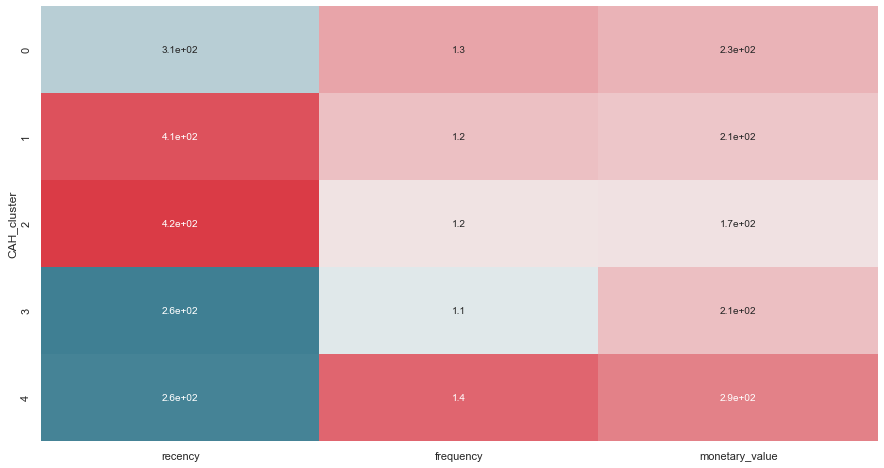

In [60]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_CAH_gb, cmap=cmap, annot=df_CAH_gb_real_val_gb,
            annot_kws={'size': 10}, cbar=None)

## CAH RFM (3 variables)

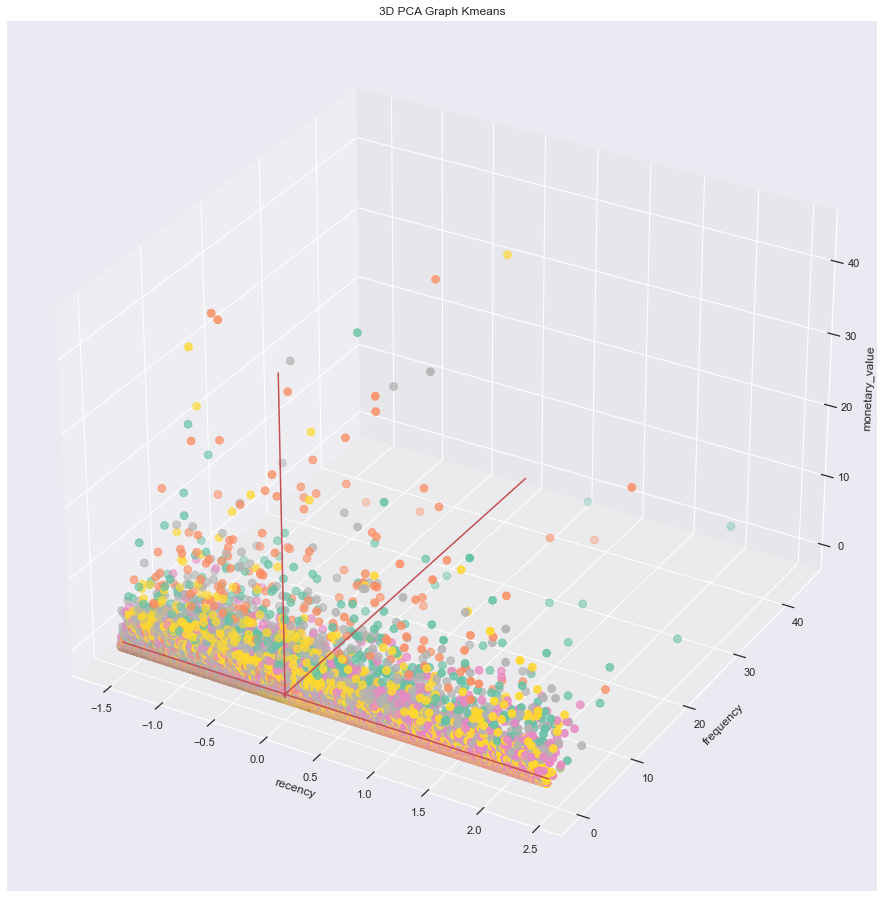

In [61]:
my_color = df_CAH["CAH_cluster"]


# Plot initialisation
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_CAH['recency'], df_CAH['frequency'],
           df_CAH['monetary_value'], c=my_color, cmap="Set2_r", s=60)

# make simple, bare axis lines through space:
xAxisLine = ((min(df_CAH['recency']), max(
    df_CAH['recency'])), (0, 0), (0, 0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(df_CAH['frequency']), max(
    df_CAH['frequency'])), (0, 0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0, 0),
             (min(df_CAH['monetary_value']), max(df_CAH['monetary_value'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')


# label the axes
ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("monetary_value")
ax.set_title("3D PCA Graph Kmeans")
plt.show()

## CAH Recense / Frequence

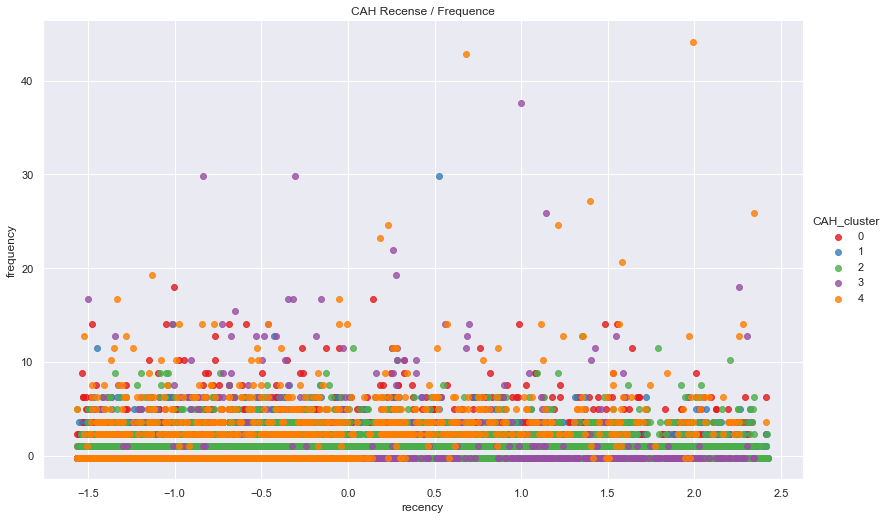

In [62]:
sns.set()
sns.lmplot(
    x='recency',
    y='frequency',
    data=df_CAH,
    hue='CAH_cluster',
    fit_reg=False,
    legend=True,
    palette="Set1",
    height=7, aspect=1.6)

plt.title('CAH Recense / Frequence')
plt.show()

## CAH Recense / Montant

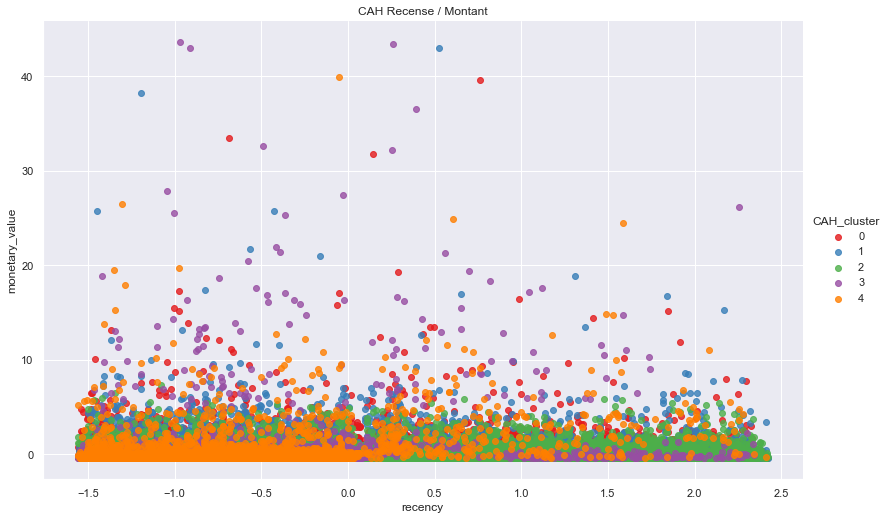

In [63]:
sns.set()
sns.lmplot(
    x='recency',
    y='monetary_value',
    data=df_CAH,
    hue='CAH_cluster',
    fit_reg=False,
    legend=True,
    palette="Set1",
    height=7, aspect=1.6)

plt.title('CAH Recense / Montant')
plt.show()

## CAH Frequence / Montant 

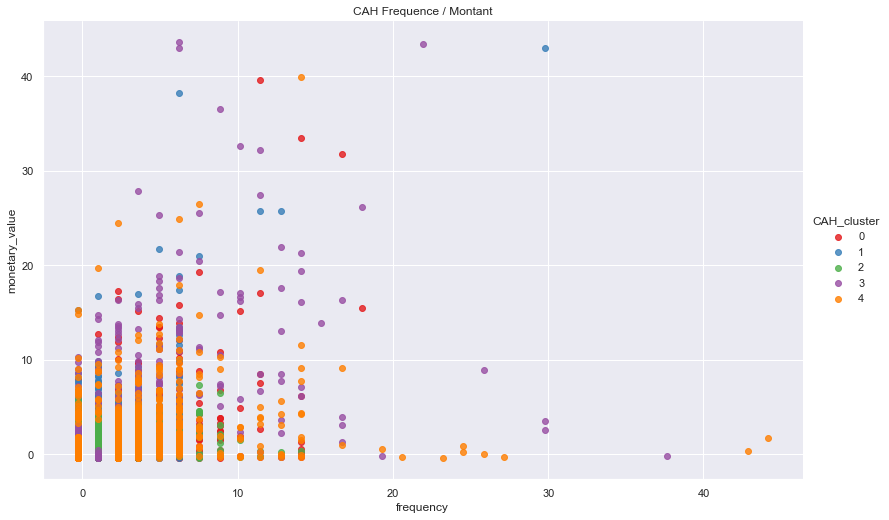

In [64]:
sns.set()
sns.lmplot(
    x='frequency',
    y='monetary_value',
    data=df_CAH,
    hue='CAH_cluster',
    fit_reg=False,
    legend=True,
    palette="Set1",
    height=7, aspect=1.6)

plt.title('CAH Frequence / Montant')
plt.show()

# Cluster Analysis

In [65]:
df_rfm_class = rfmSegmentation[['RFMClass']]

In [66]:
df_agg = df.groupby('customer_unique_id').agg({'temps_session': lambda x: x.mean(),  
                                                   'experience_client': lambda x: x.mean(),     
                                                   'temps_livraison_estime': lambda x: x.mean(),
                                                   'review_score': lambda x: x.mean(),
                                                  'temps_de_reponse': lambda x: x.mean(),
                                                  'longueur_comment_message': lambda x: x.mean()})

In [67]:
df.drop(['order_id','order_item_id','payment_value','temps_session', 'experience_client', 'temps_livraison_estime',
       'review_score', 'temps_de_reponse', 'longueur_comment_message',
       'customer_zip_code_prefix',
       'order_item_id', 'benefice', 'product_weight_g', 'product_volume_cm3',
       'product_category_name_english'],axis=1,inplace=True)

In [68]:
df_category = df.groupby('customer_unique_id')['bed_bath_table', 'health_beauty', 'sports_leisure',
       'furniture_decor', 'computers_accessories', 'housewares',
       'watches_gifts', 'telephony', 'garden_tools', 'auto', 'toys',
       'cool_stuff', 'perfumery', 'baby', 'electronics', 'stationery',
       'fashion_bags_accessories', 'pet_shop', 'office_furniture',
       'luggage_accessories', 'consoles_games',
       'construction_tools_construction', 'home_appliances',
       'small_appliances', 'musical_instruments', 'home_construction',
       'books_general_interest', 'furniture_living_room', 'food',
       'home_confort', 'audio', 'drinks', 'market_place',
       'construction_tools_lights', 'kitchen_dining_laundry_garden_furniture',
       'air_conditioning', 'food_drink', 'fashion_shoes',
       'industry_commerce_and_business', 'books_technical'].agg('sum')

In [69]:
df_merge = pd.merge(df_kmeans_real_val,df_category , on="customer_unique_id")

In [70]:
df_merge_agg = pd.merge(df_merge,df_agg, on="customer_unique_id")

In [71]:
df_final = pd.merge(df_merge_agg,df_rfm_class, on="customer_unique_id")

In [72]:
# with order approved
df_time_date=df[['customer_unique_id','order_approved_at']]

In [73]:
df_final_date = pd.merge(df_time_date,df_final, on="customer_unique_id")

In [74]:
df_final.drop(['customer_unique_id'],axis=1,inplace=True)

In [75]:
df_final

recency  frequency  monetary_value  Kmeans_cluster  bed_bath_table  \
0          234        1.0          141.90               1               1   
1          237        1.0           27.19               1               0   
2          660        1.0           86.22               3               0   
3          444        1.0           43.62               3               0   
4          411        1.0          196.89               3               0   
...        ...        ...             ...             ...             ...   
91069      570        2.0         4134.84               0               0   
91070      385        1.0           84.58               3               0   
91071      691        1.0          112.46               3               0   
91072      242        1.0          133.69               1               0   
91073      606        1.0           71.56               3               0   

       health_beauty  sports_leisure  furniture_decor  computers_accessories  \
0                  0               0                0                      0   
1                  1               0                0                      0   
2                  0               0                0                      0   
3                  0               0                0                      0   
4                  0               0                0                      0   
...              ...             ...              ...                    ...   
91069              2               0                0                      0   
91070              0               0                0                      0   
91071              0               0                0                      0   
91072              0               0                0                      0   
91073              0               0                0                      0   

       housewares  ...  fashion_shoes  industry_commerce_and_business  \
0               0  ...              0                               0   
1               0  ...              0                               0   
2               0  ...              0                               0   
3               0  ...              0                               0   
4               0  ...              0                               0   
...           ...  ...            ...                             ...   
91069           0  ...              0                               0   
91070           0  ...              0                               0   
91071           0  ...              0                               0   
91072           0  ...              0                               0   
91073           0  ...              0                               0   

       books_technical  temps_session  experience_client  \
0                    0          891.0           553930.0   
1                    0        26057.0           283875.0   
2                    0            0.0          2223224.0   
3                    0         1176.0          1731204.0   
4                    0         1270.0          1135394.0   
...                ...            ...                ...   
91069                0          880.0          2377284.0   
91070                0          504.0          2600424.0   
91071                0          808.0          1284948.0   
91072                0         2466.0          1024605.0   
91073                0        68188.0           652503.0   

       temps_livraison_estime  review_score  temps_de_reponse  \
0                    910122.0           5.0          4.572778   
1                    624856.0           4.0          0.937095   
2                   2343297.0           3.0          1.055370   
3                   2689843.0           4.0          1.012396   
4                   1741988.0           5.0          4.937211   
...                       ...           ...               ...   
91069               4675484.0           5.0          4.472280   
910

In [76]:
df_final.columns

Index(['recency', 'frequency', 'monetary_value', 'Kmeans_cluster',
       'bed_bath_table', 'health_beauty', 'sports_leisure', 'furniture_decor',
       'computers_accessories', 'housewares', 'watches_gifts', 'telephony',
       'garden_tools', 'auto', 'toys', 'cool_stuff', 'perfumery', 'baby',
       'electronics', 'stationery', 'fashion_bags_accessories', 'pet_shop',
       'office_furniture', 'luggage_accessories', 'consoles_games',
       'construction_tools_construction', 'home_appliances',
       'small_appliances', 'musical_instruments', 'home_construction',
       'books_general_interest', 'furniture_living_room', 'food',
       'home_confort', 'audio', 'drinks', 'market_place',
       'construction_tools_lights', 'kitchen_dining_laundry_garden_furniture',
       'air_conditioning', 'food_drink', 'fashion_shoes',
       'industry_commerce_and_business', 'books_technical', 'temps_session',
       'experience_client', 'temps_livraison_estime', 'review_score',
       'temps_de_rep

## Data Cluster Analysis

In [77]:
df_values = df_final.groupby('Kmeans_cluster')['recency', 'frequency', 'monetary_value','temps_session',
          'experience_client', 'temps_livraison_estime', 'review_score',
          'temps_de_reponse', 'longueur_comment_message'].agg('mean')

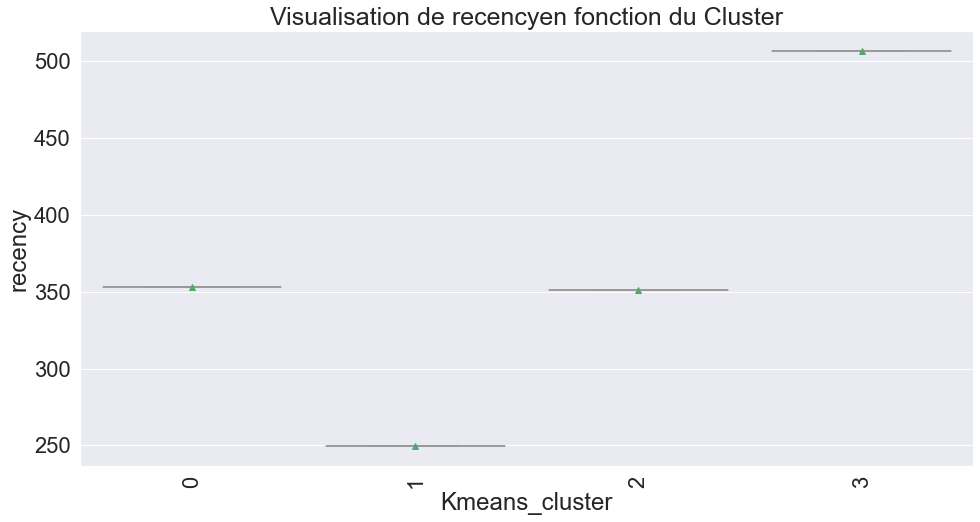

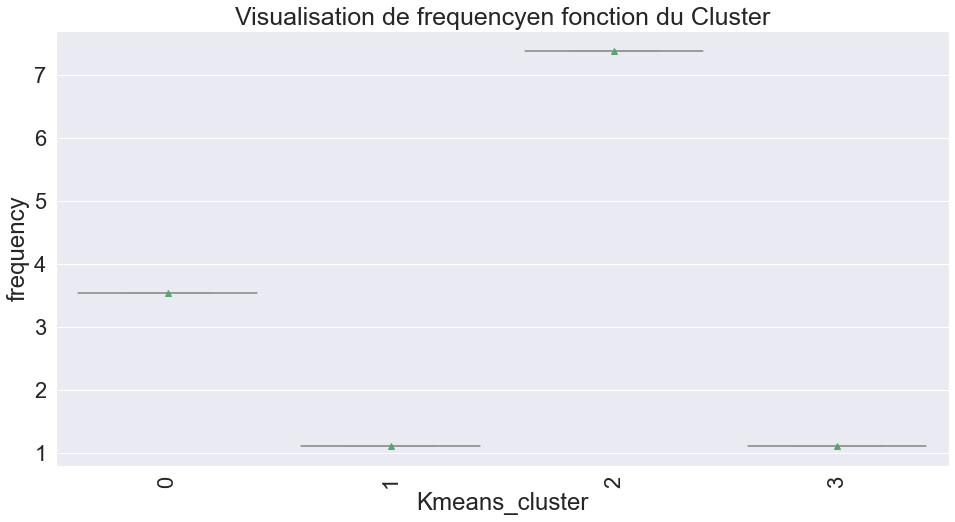

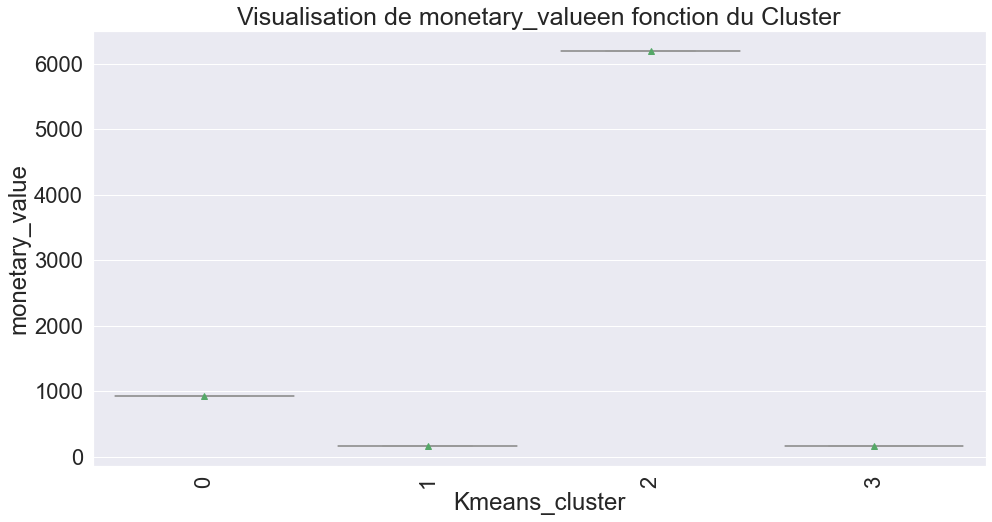

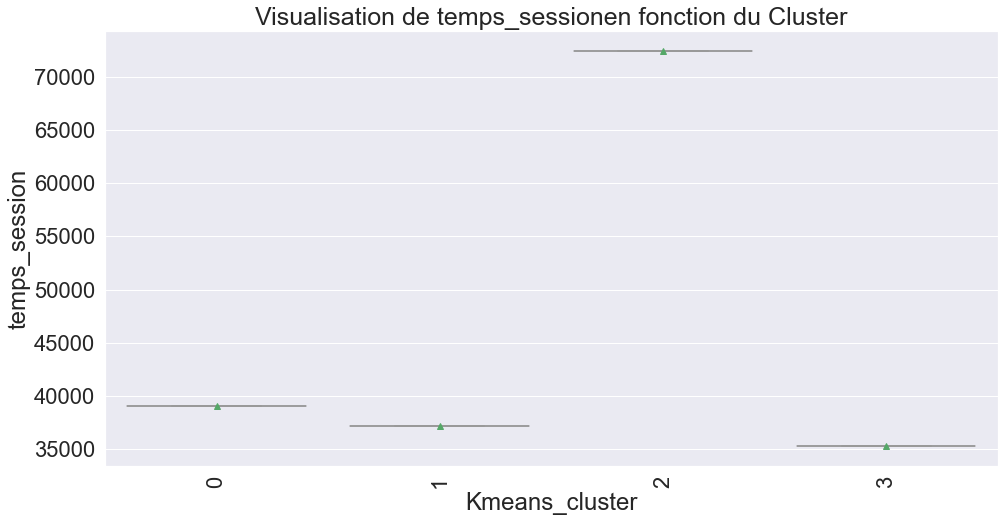

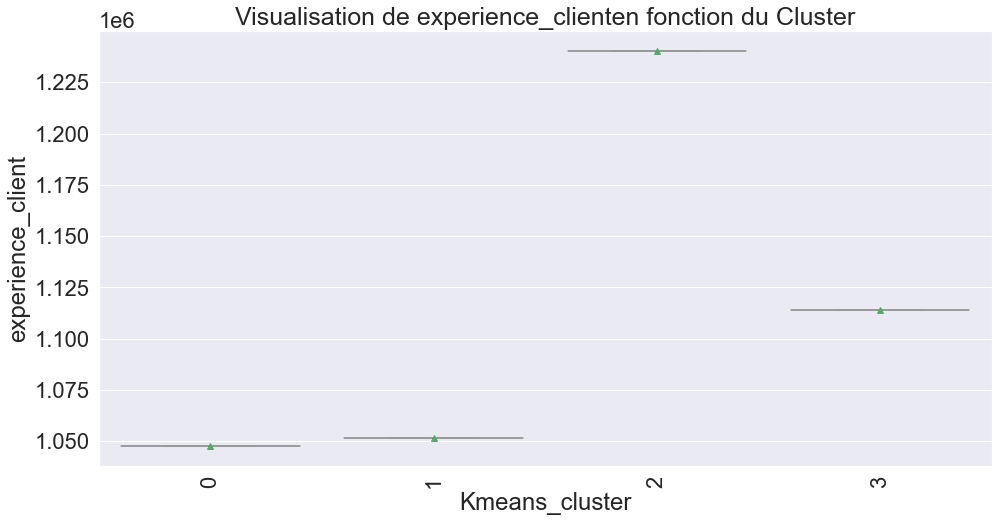

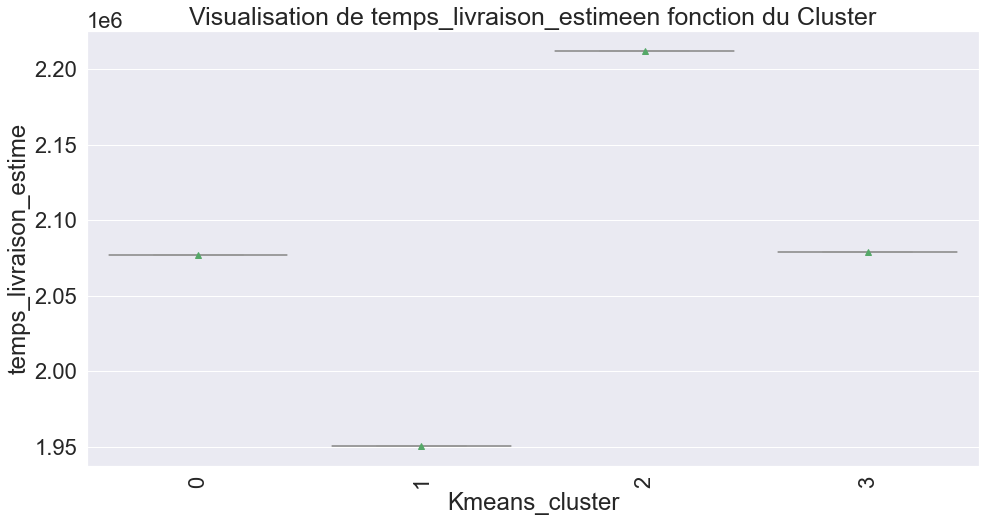

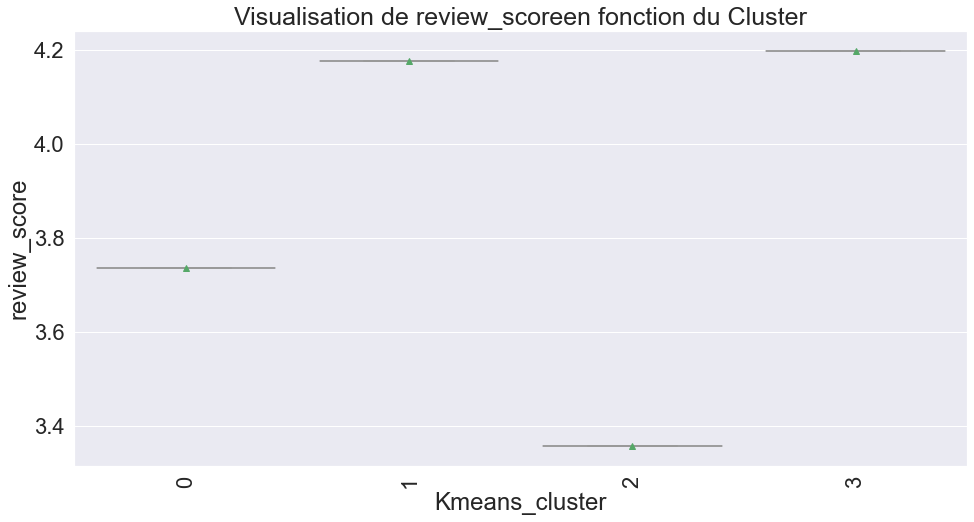

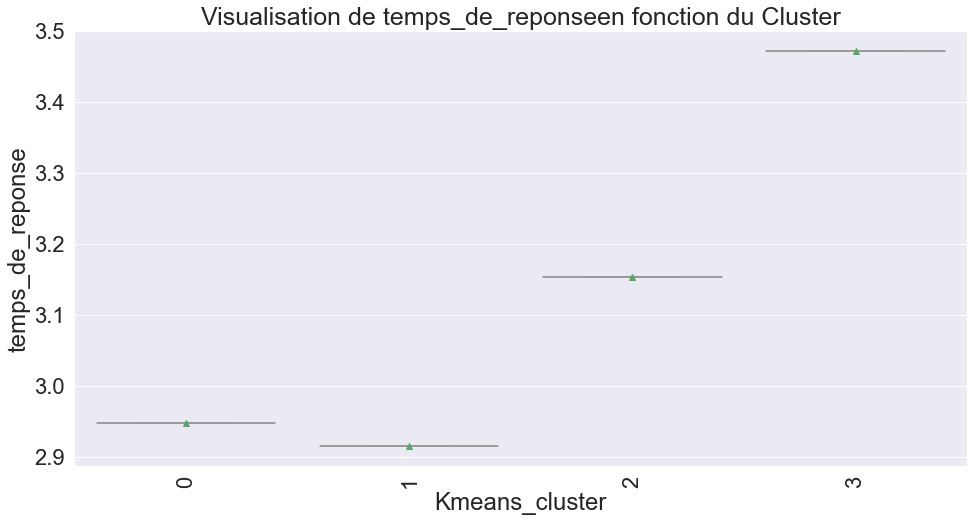

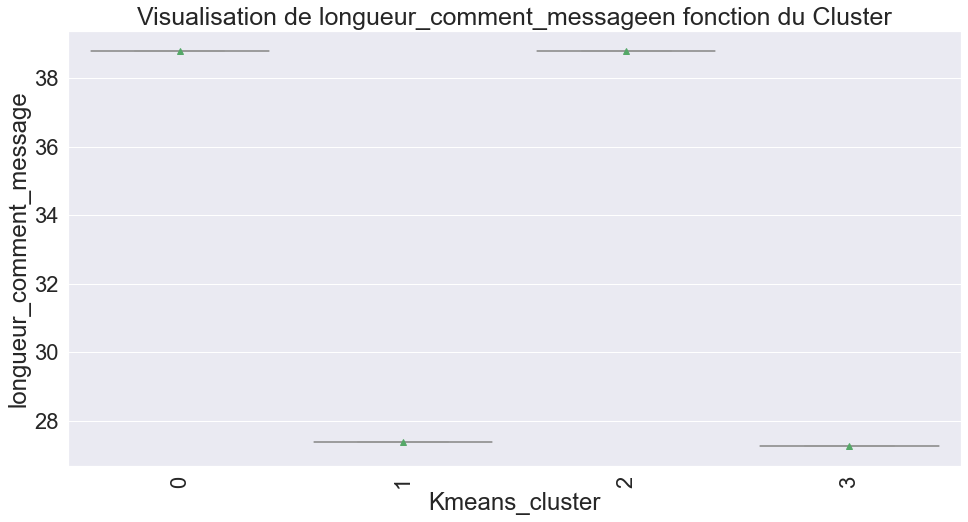

In [78]:
for col in df_values:
    plt.figure(figsize=[16, 8])
    sns.set(font_scale=2)
    sns.boxplot(x=df_values.index, y=col, data=df_values, showmeans=True,color='white')
    plt.title("Visualisation de "+ col + "en fonction du Cluster", fontsize=25)
    plt.xticks(rotation='90')
    plt.show()

In [79]:
df_categ = df_final.groupby('Kmeans_cluster')['bed_bath_table', 'health_beauty', 'sports_leisure',
       'furniture_decor', 'computers_accessories', 'housewares',
       'watches_gifts', 'telephony', 'garden_tools', 'auto', 'toys',
       'cool_stuff', 'perfumery', 'baby', 'electronics', 'stationery',
       'fashion_bags_accessories', 'pet_shop', 'office_furniture',
       'luggage_accessories', 'consoles_games',
       'construction_tools_construction', 'home_appliances',
       'small_appliances', 'musical_instruments', 'home_construction',
       'books_general_interest', 'furniture_living_room', 'food',
       'home_confort', 'audio', 'drinks', 'market_place',
       'construction_tools_lights', 'kitchen_dining_laundry_garden_furniture',
       'air_conditioning', 'food_drink', 'fashion_shoes',
       'industry_commerce_and_business', 'books_technical'].agg('sum')

In [80]:
df_categ

bed_bath_table  health_beauty  sports_leisure  \
Kmeans_cluster                                                  
0                         1973            821             962   
1                         5299           5577            4241   
2                          190             69              32   
3                         4166           3137            3438   

                furniture_decor  computers_accessories  housewares  \
Kmeans_cluster                                                       
0                          2040                   1025        1078   
1                          3315                   4175        3490   
2                           178                    225         160   
3                          2911                   2427        2342   

                watches_gifts  telephony  garden_tools  auto  ...  audio  \
Kmeans_cluster                                                ...          
0                         424        238           713   377  ...     13   
1                        3563       2302          1673  2508  ...    204   
2                          53         33           117    30  ...      0   
3                        1957       1937          1921  1305  ...    157   

                drinks  market_place  construction_tools_lights  \
Kmeans_cluster                                                    
0                   76            29                         86   
1                  225           101                        208   
2                    5             2                          0   
3                   54           178                         14   

                kitchen_dining_laundry_garden_furniture  air_conditioning  \
Kmeans_cluster                                                              
0                                                    33                37   
1                                                   147               133   
2                                                     5                 7   
3                                                   101               108   

                food_drink  fashion_shoes  industry_commerce_and_business  \
Kmeans_cluster                                                              
0                       56             30                              27   
1                      124             71                             208   
2                        0              0                               0   
3                       99            166                              28   

                books_technical  
Kmeans_cluster                   
0                             7  
1                           212  
2                             0  
3                            44  

[4 rows x 40 columns]

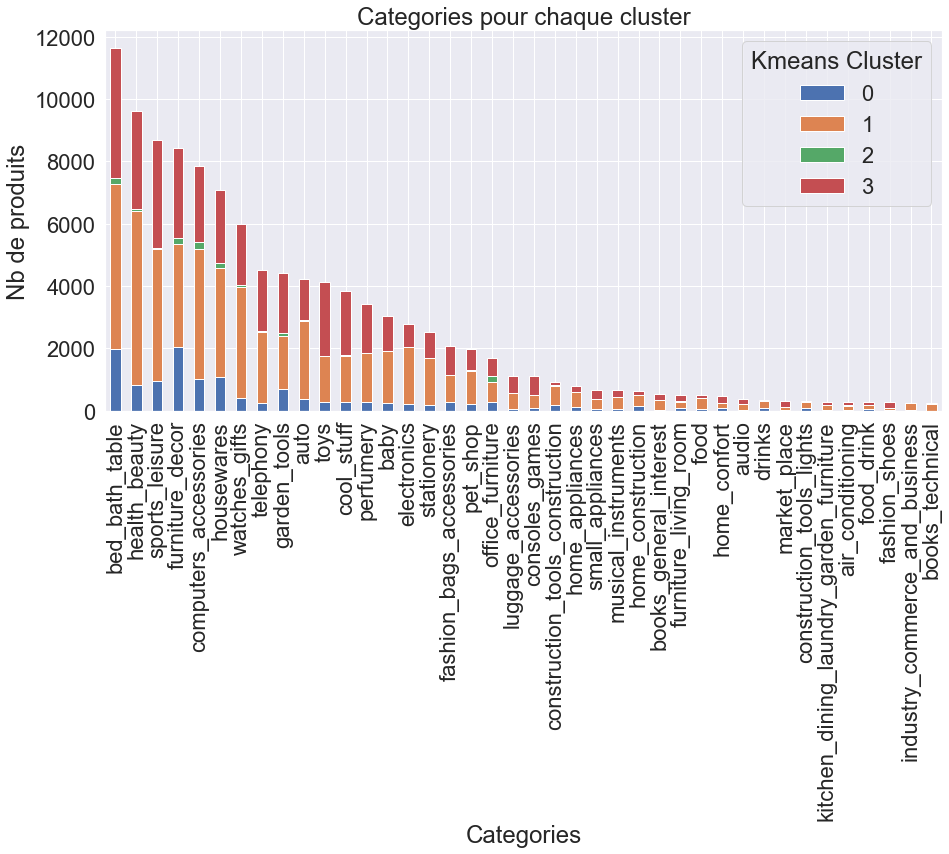

In [81]:
df_categ.T.plot(kind="bar", stacked=True, figsize=(15,7))
plt.legend(title="Kmeans Cluster")
plt.xlabel("Categories")
plt.ylabel("Nb de produits")
plt.title("Categories pour chaque cluster")
plt.show()

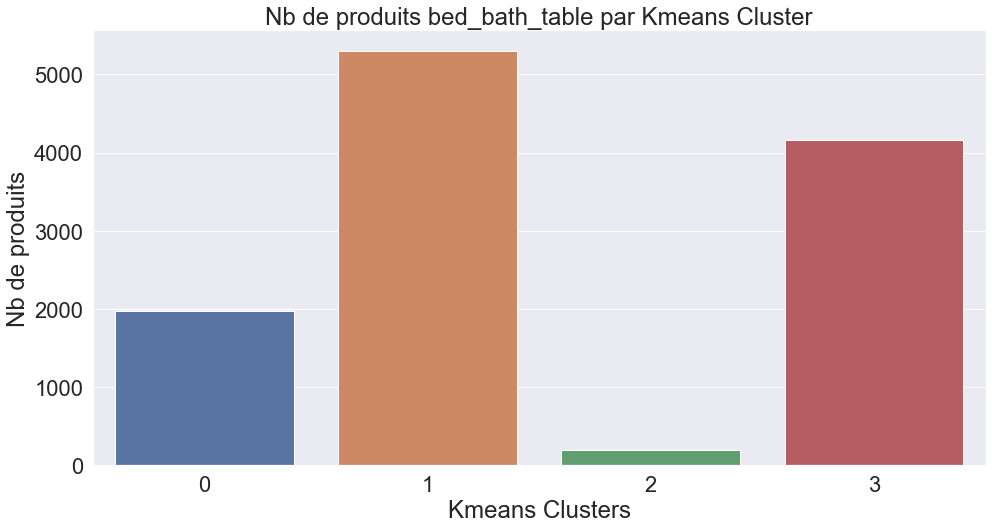

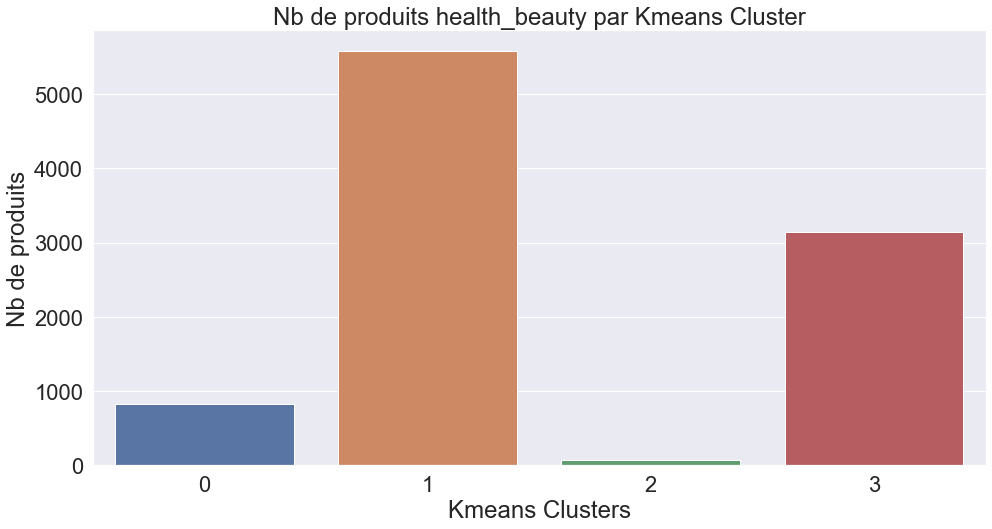

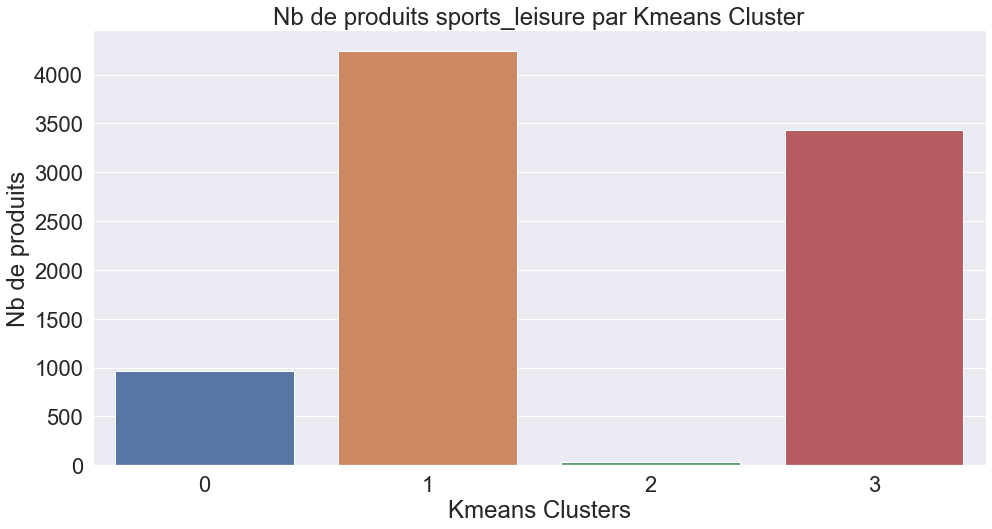

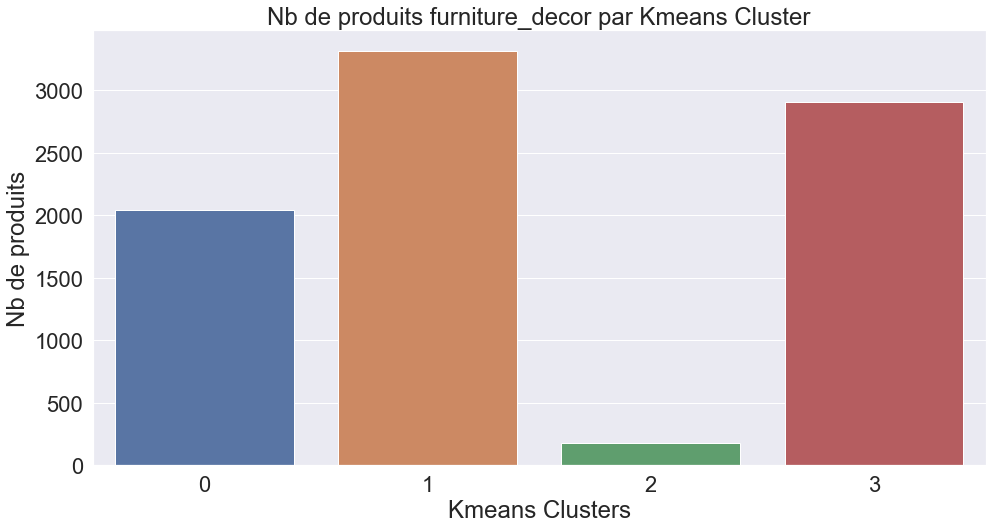

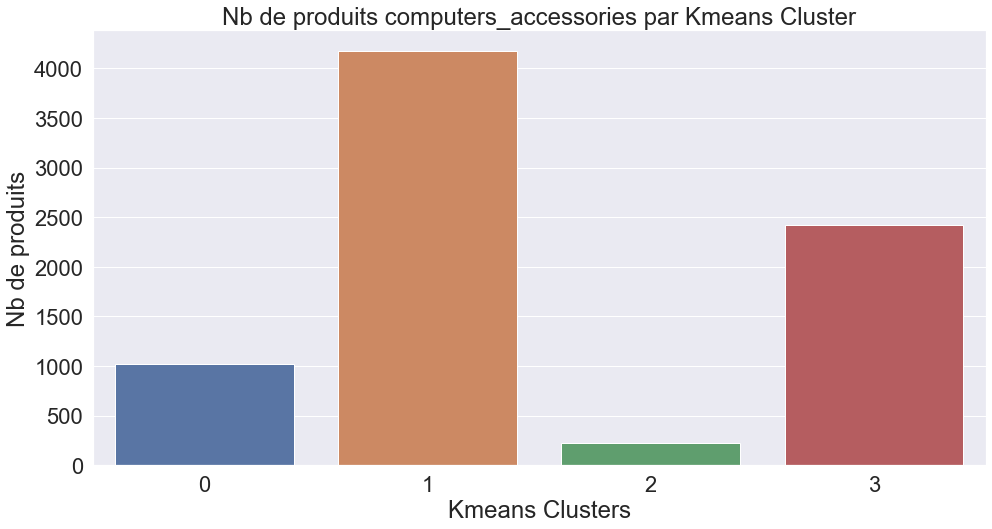

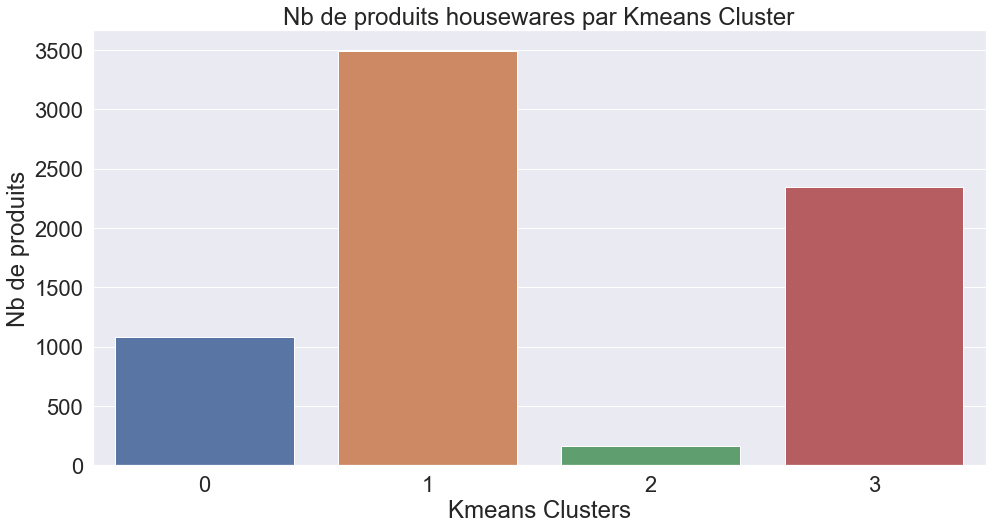

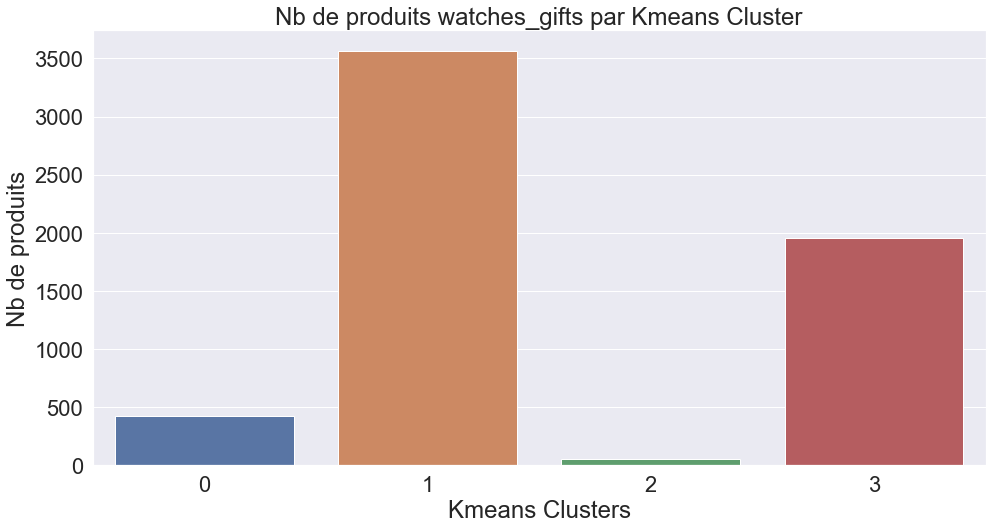

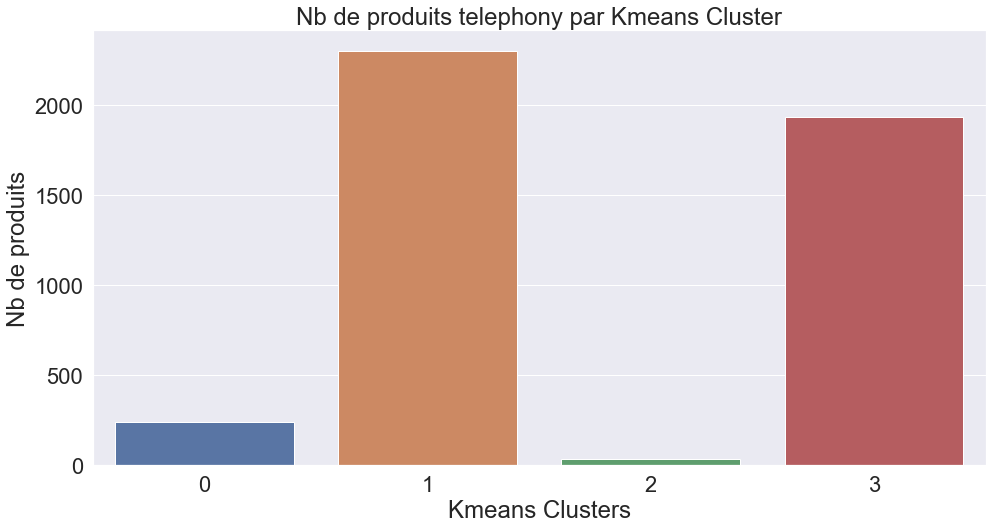

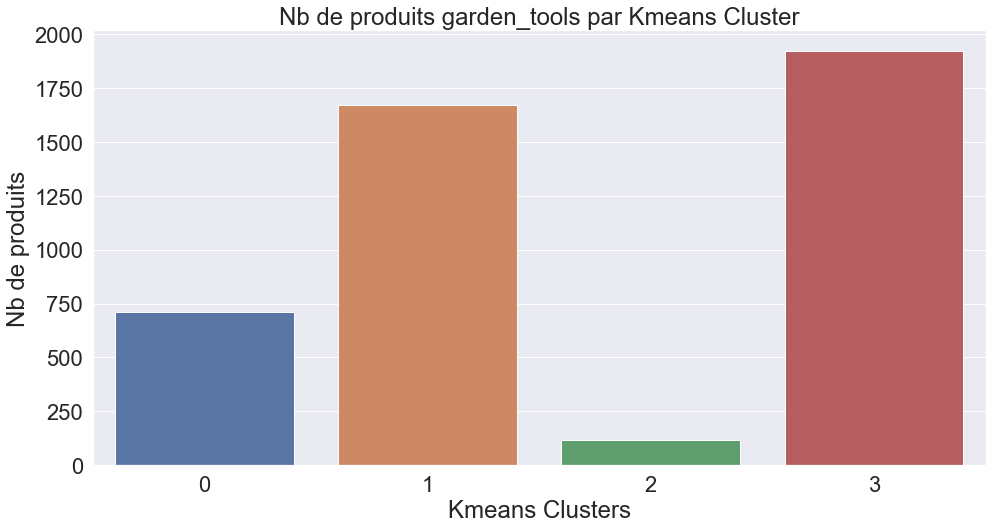

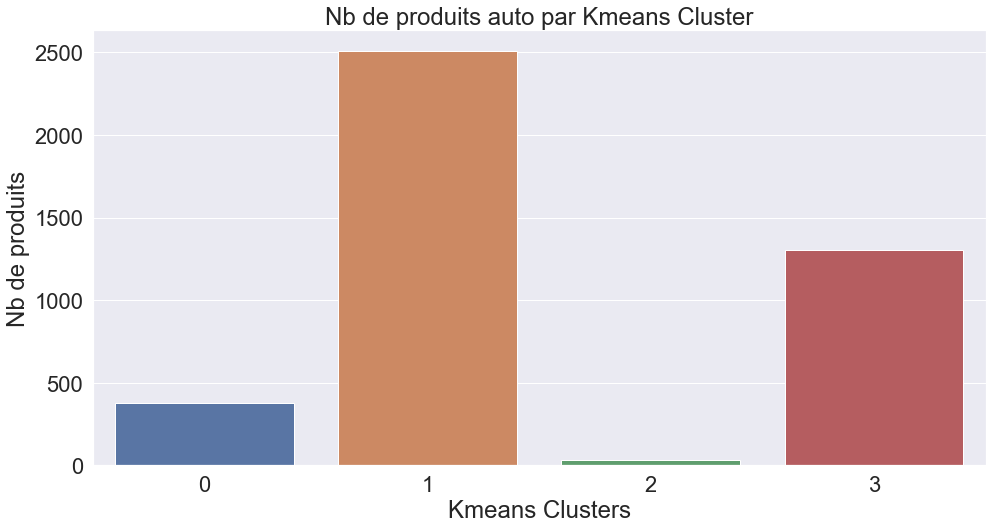

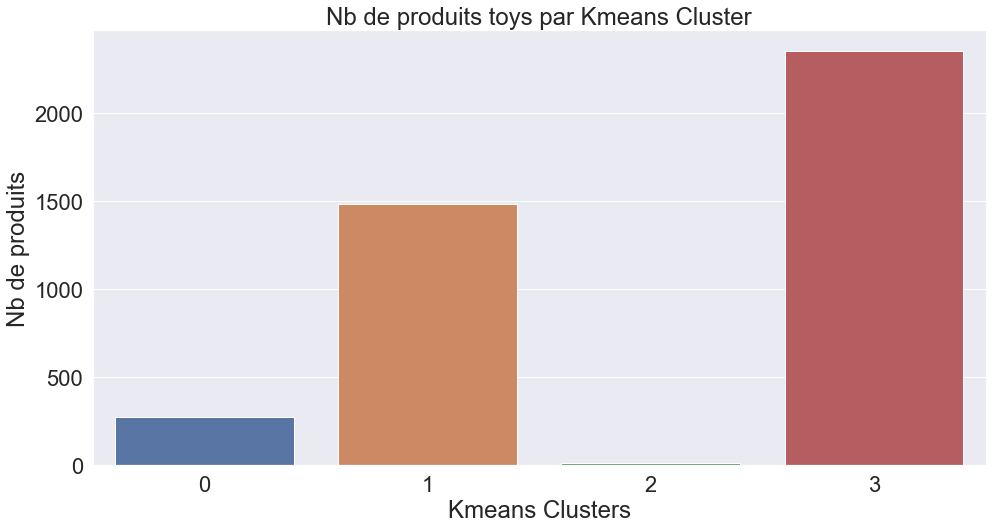

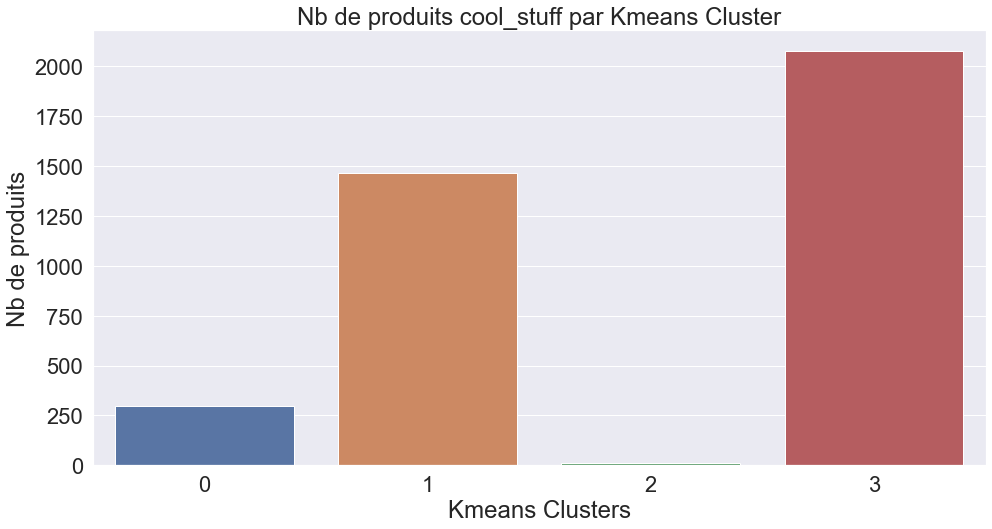

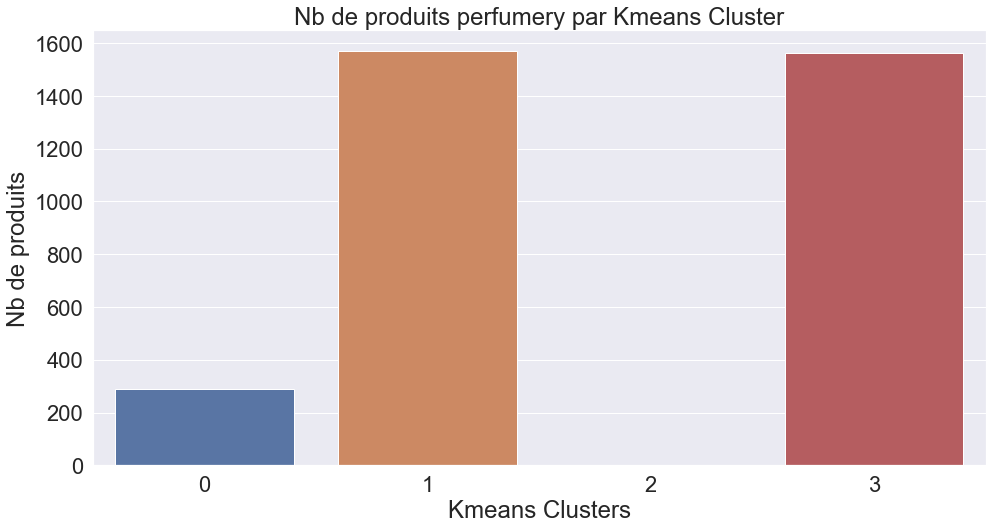

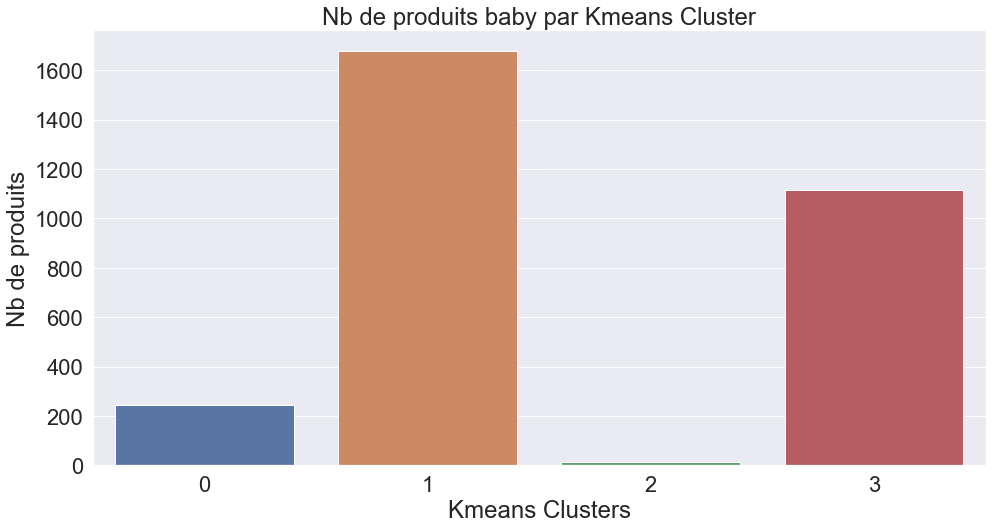

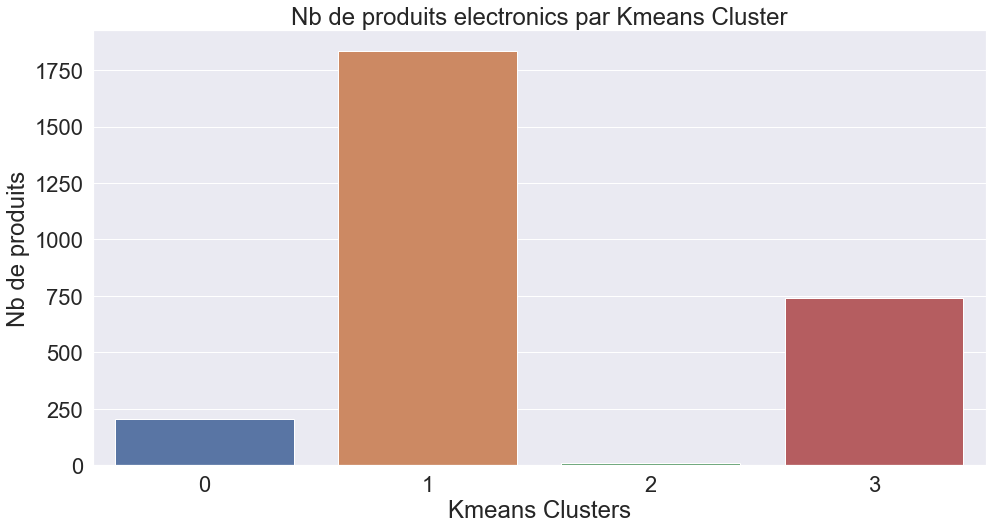

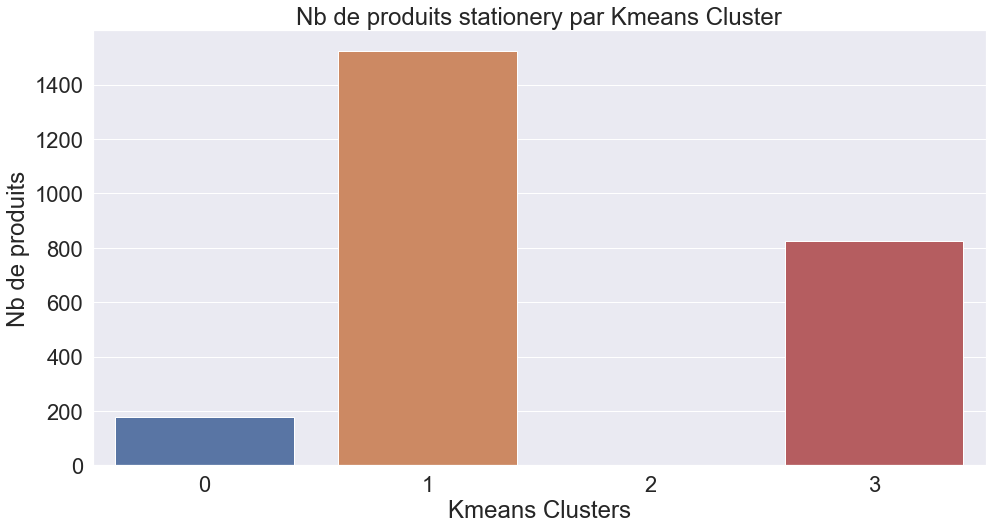

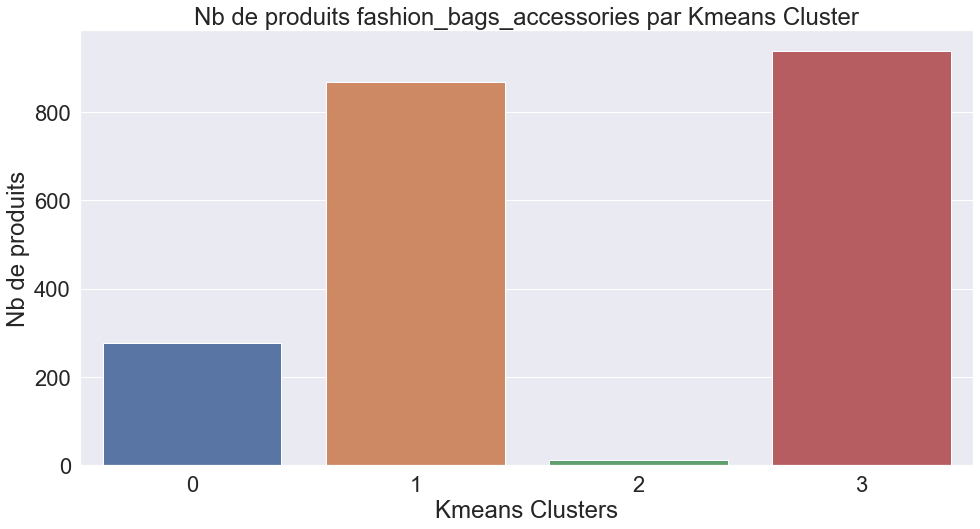

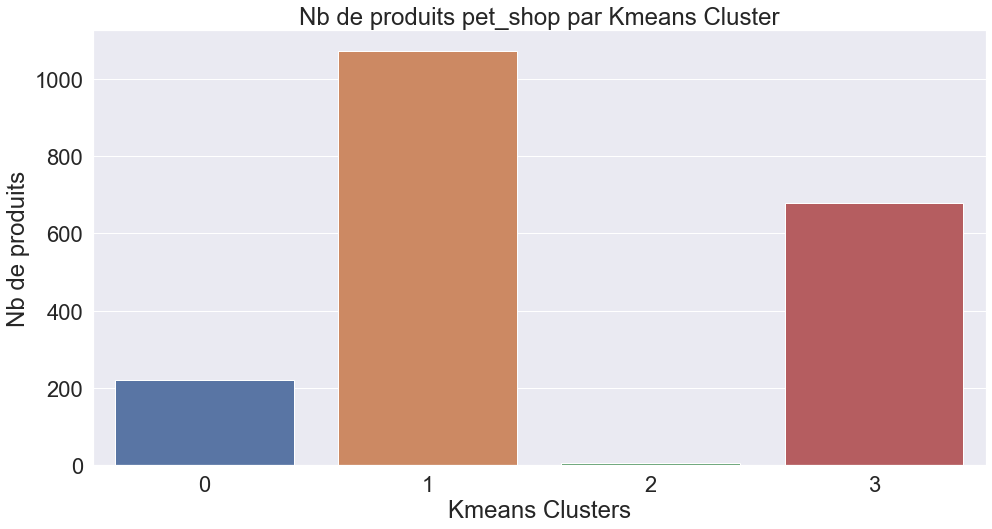

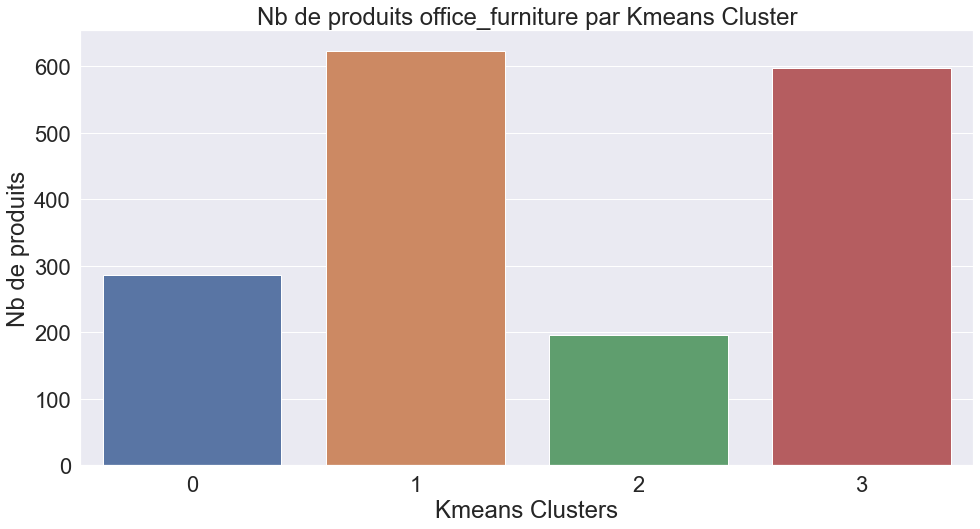

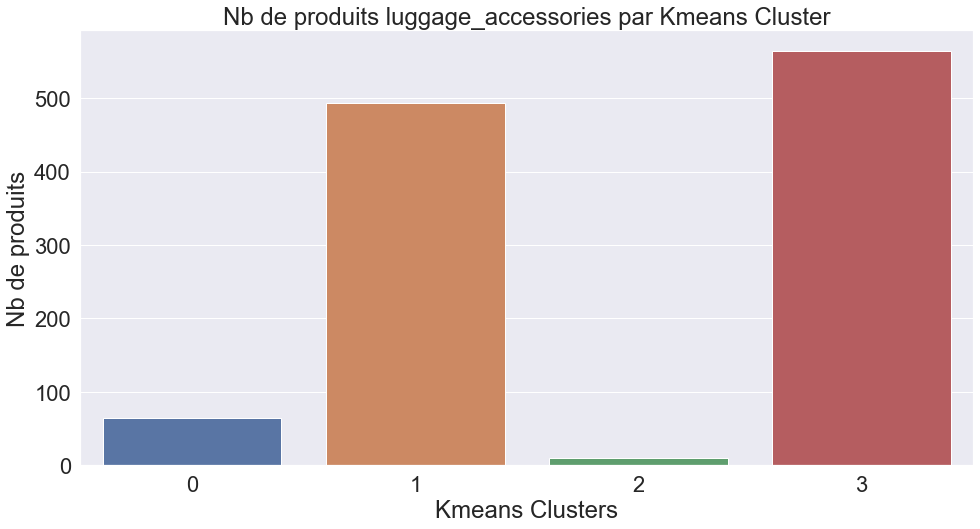

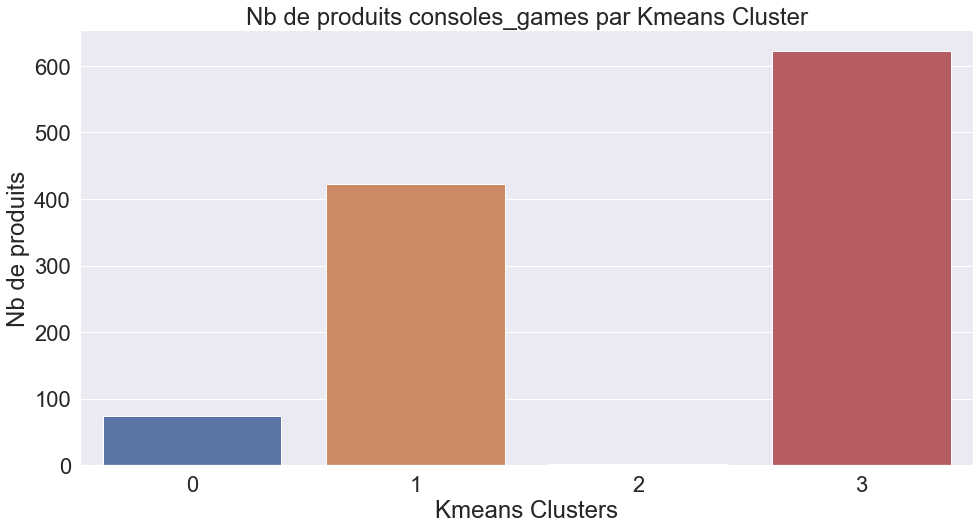

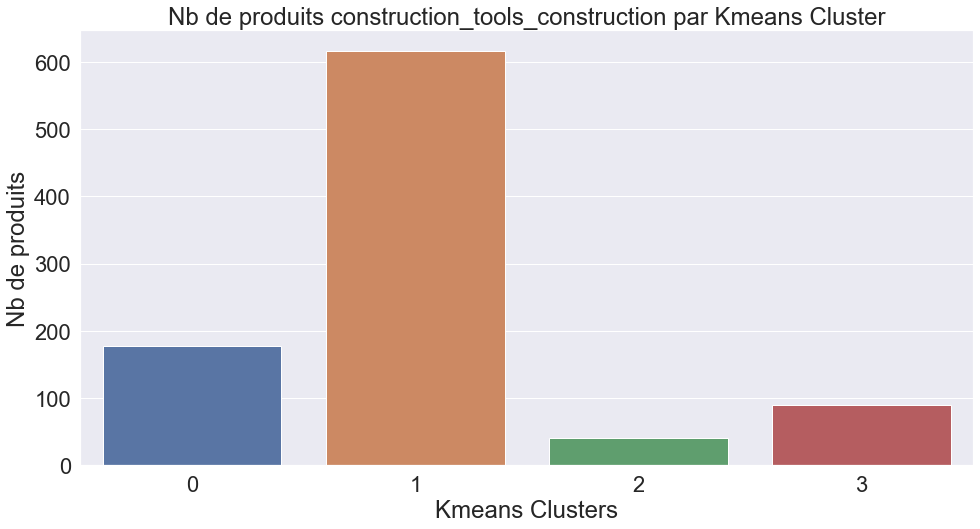

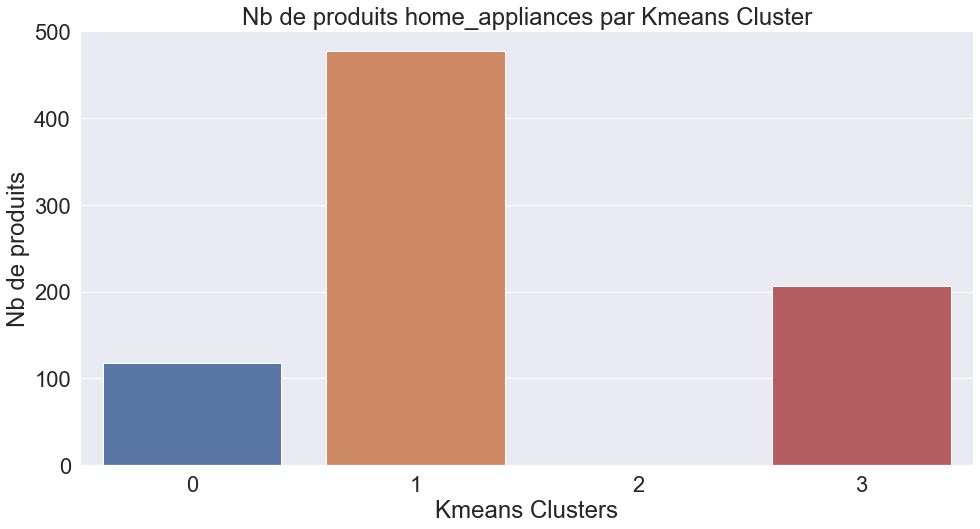

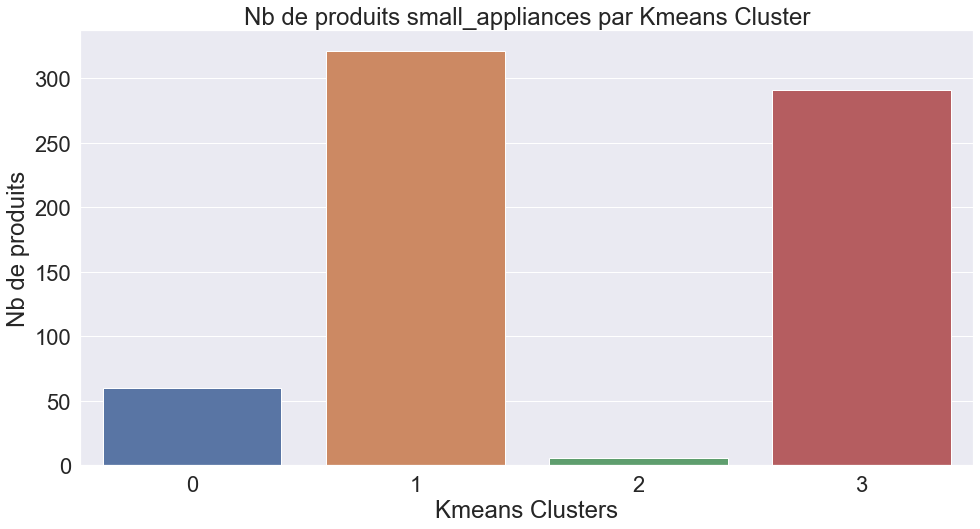

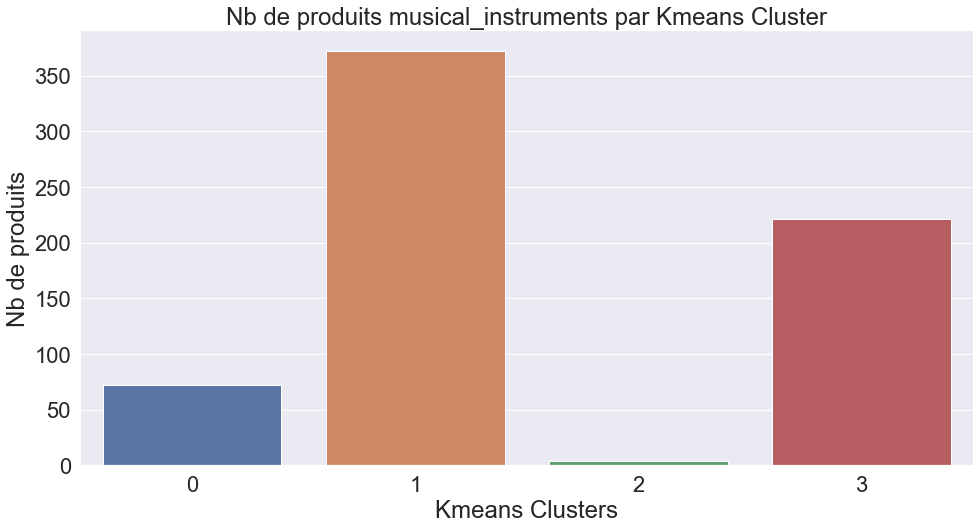

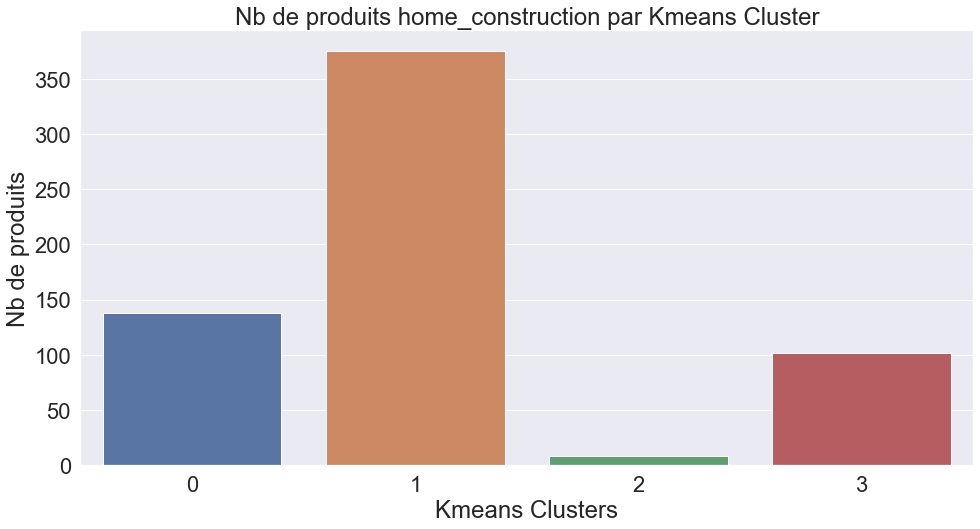

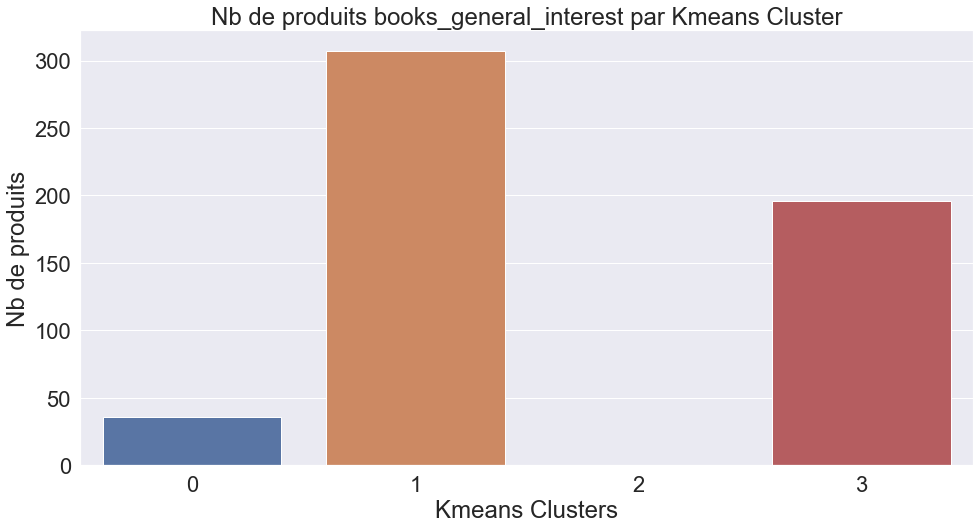

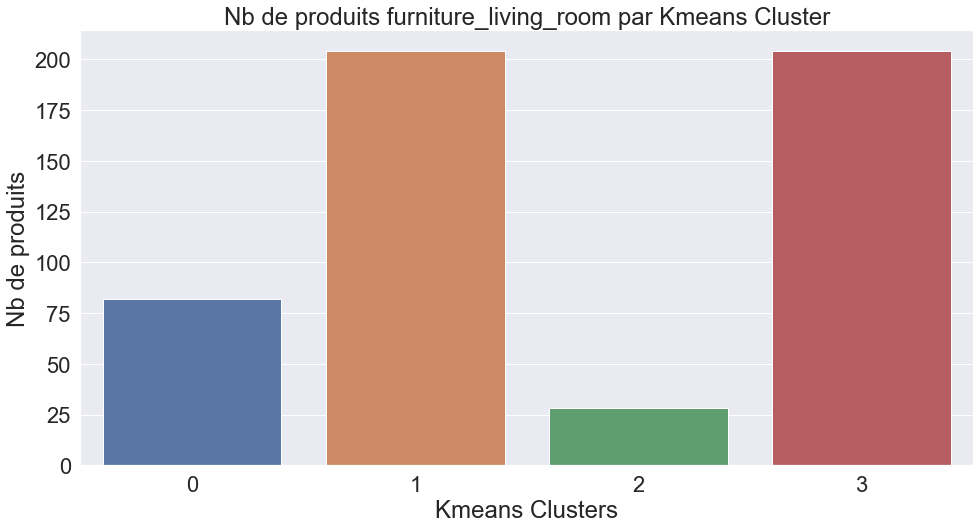

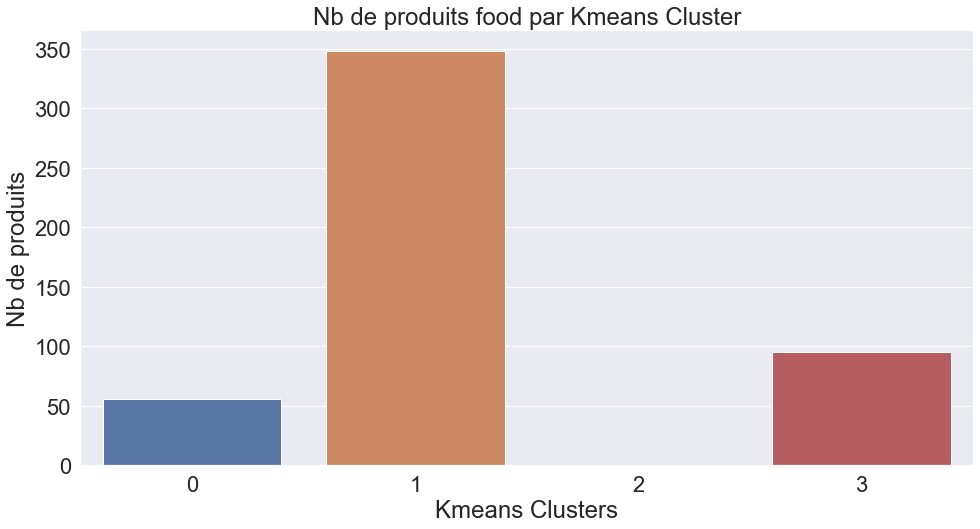

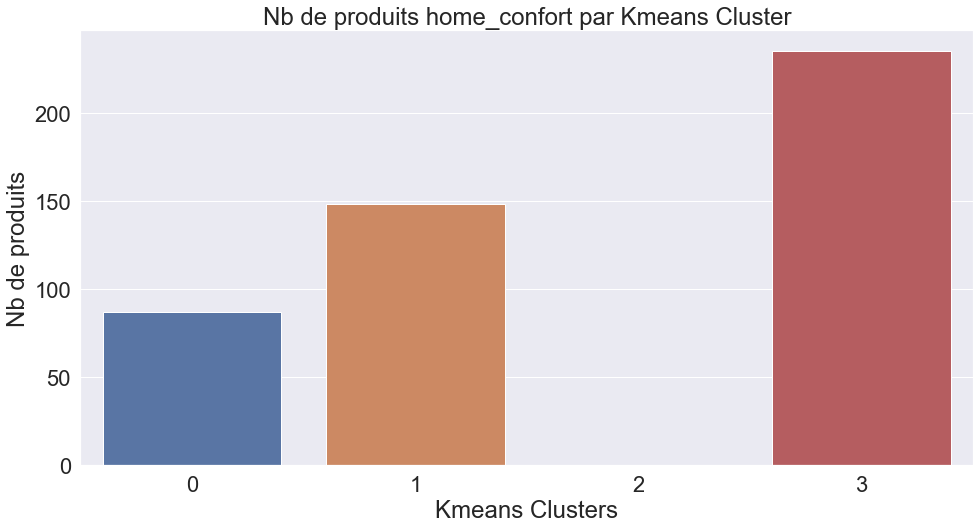

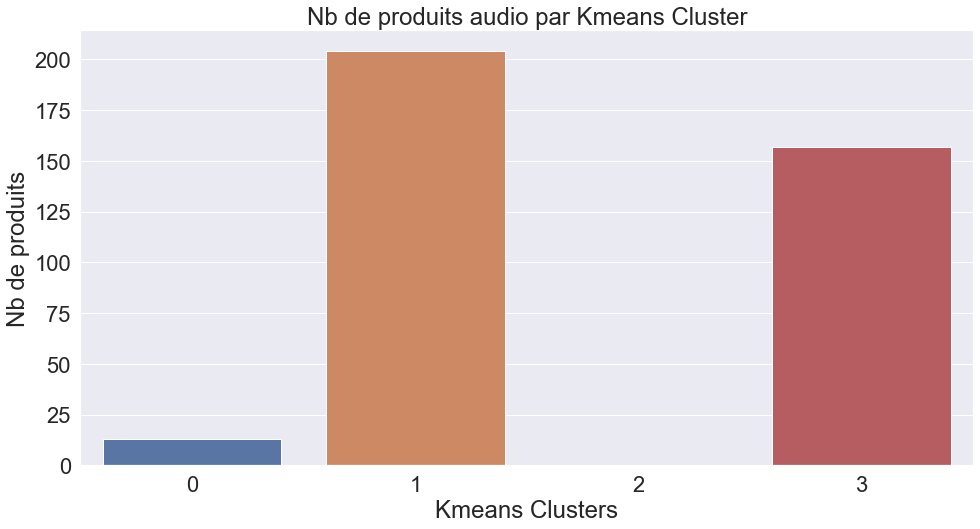

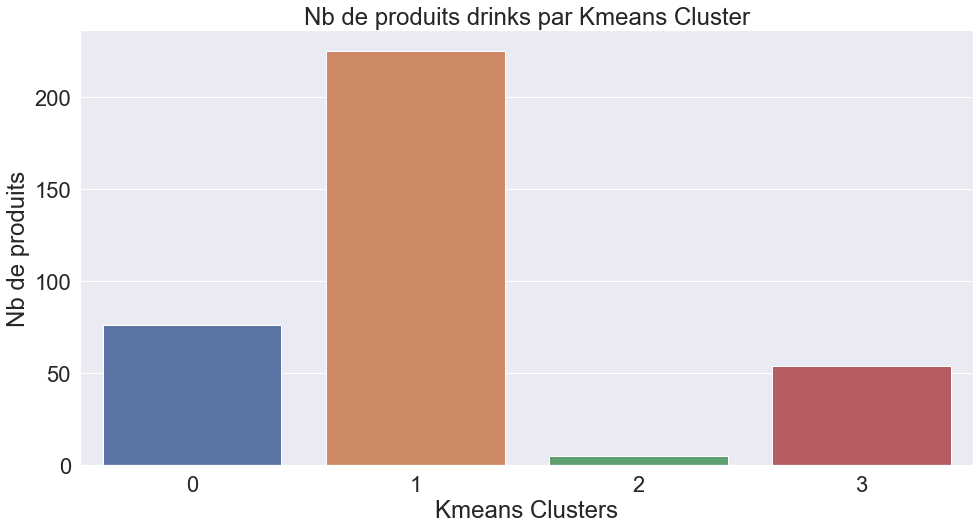

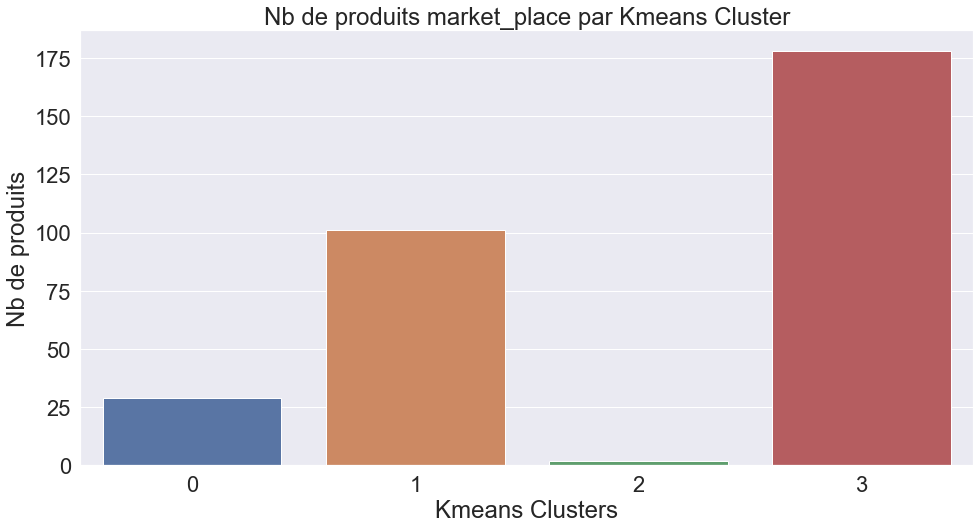

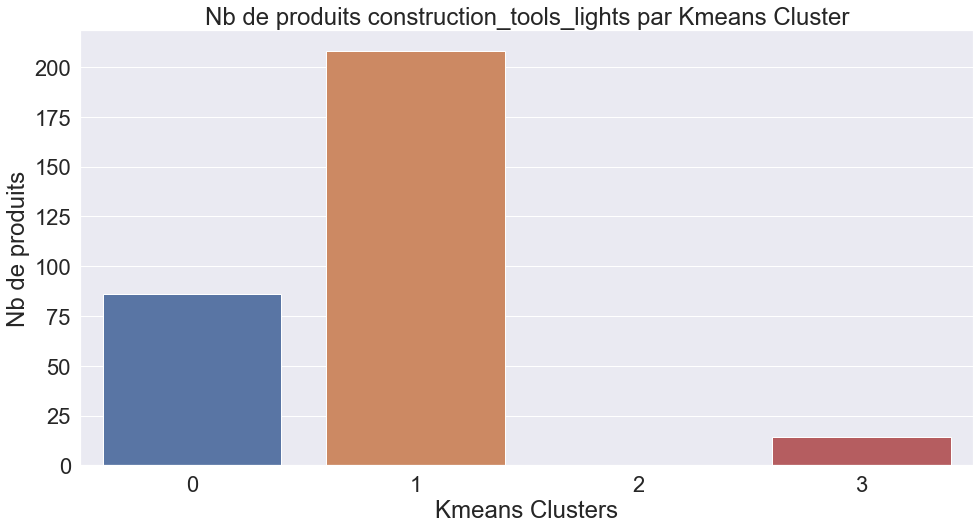

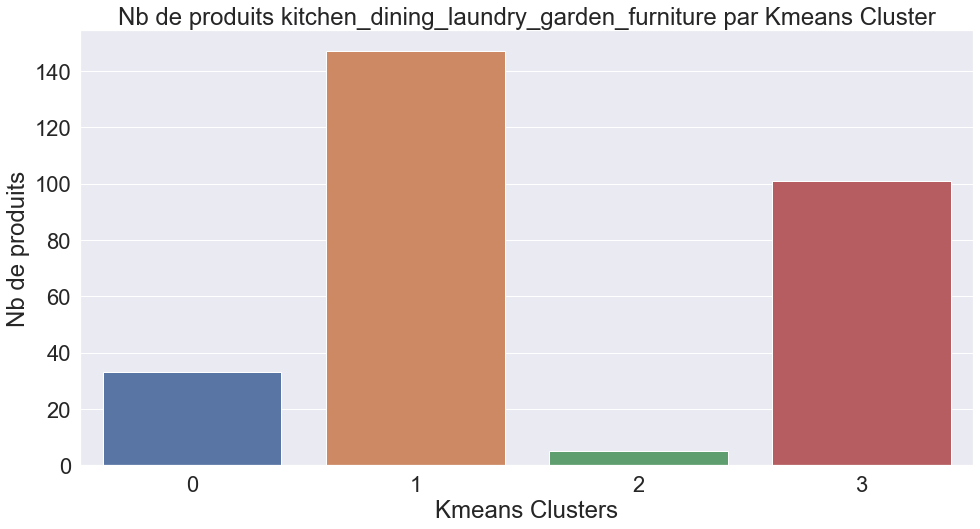

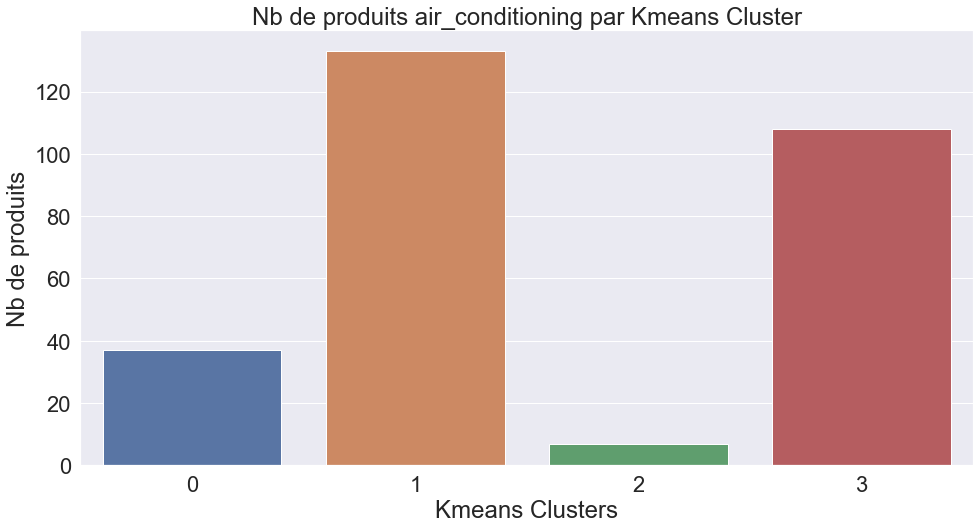

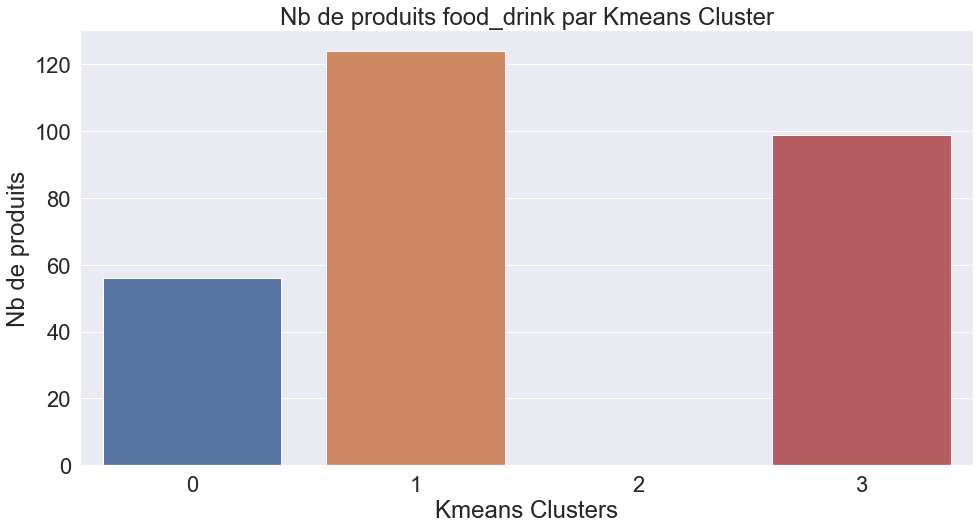

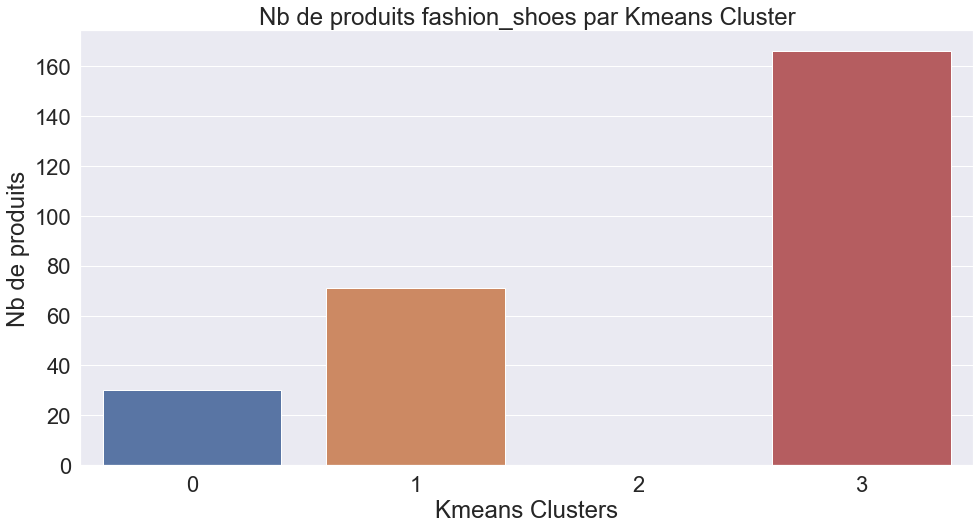

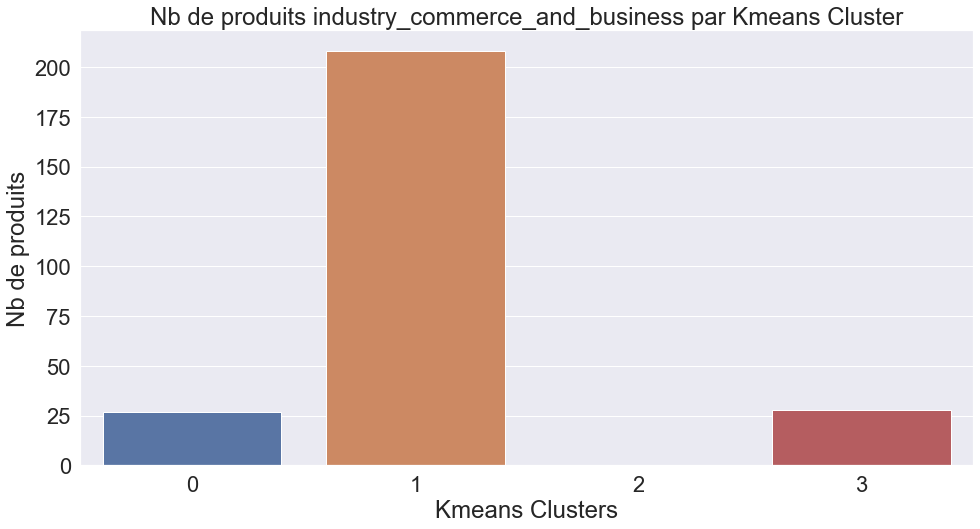

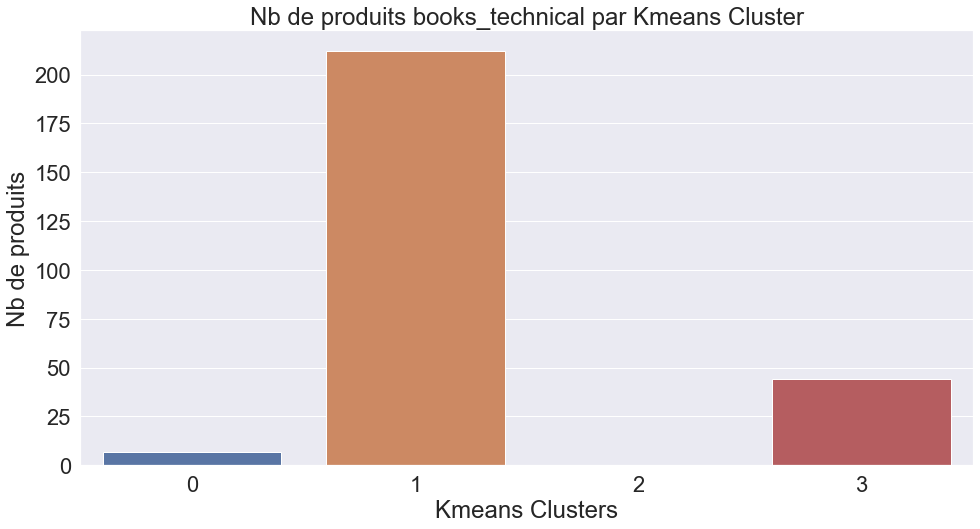

In [82]:
for category in df_categ:
    plt.figure(figsize=[16, 8])
    sns.set(font_scale=2)
    sns.barplot(x=df_categ.index,
                y=category,
                data=df_categ)
    plt.xlabel("Kmeans Clusters")
    plt.ylabel("Nb de produits")
    plt.title("Nb de produits " + category + " par Kmeans Cluster")
    plt.show()

## Time Cluster Analysis

In [83]:
df_final_date.drop(['customer_unique_id'],axis=1,inplace=True)

In [84]:
# Set_index
#df_final_date = df_final_date.set_index(
#    'order_approved_at')

In [123]:
df_final_date['Month'] = df_final_date['order_approved_at'].dt.to_period('M')
df_final_date_per_month = df_final_date.groupby(['Month', 'Kmeans_cluster']).size().unstack().fillna(0).reset_index()

In [124]:
df_final_date_per_month

Kmeans_cluster    Month       0       1      2       3
0               2017-01   163.0     9.0   48.0   695.0
1               2017-02   199.0    13.0    7.0  1650.0
2               2017-03   354.0    18.0   44.0  2600.0
3               2017-04   222.0    16.0    9.0  2341.0
4               2017-05   536.0    24.0   47.0  3548.0
5               2017-06   445.0    31.0   47.0  3113.0
6               2017-07   608.0    37.0   73.0  3853.0
7               2017-08   684.0    41.0   56.0  4168.0
8               2017-09   620.0    42.0  127.0  4111.0
9               2017-10   808.0    42.0   79.0  4371.0
10              2017-11  1211.0    58.0  135.0  7054.0
11              2017-12   780.0  1940.0   65.0  3686.0
12              2018-01   932.0  6976.0  105.0     0.0
13              2018-02   984.0  6516.0  112.0     0.0
14              2018-03  1003.0  7109.0  141.0     0.0
15              2018-04   920.0  6723.0  101.0     0.0
16              2018-05   968.0  7085.0  166.0     0.0
17              2018-06   882.0  6254.0   76.0     0.0
18              2018-07   699.0  6136.0   96.0     0.0
19              2018-08   703.0  6516.0   24.0     0.0

In [125]:
df_final_date_per_month['Month'] = df_final_date_per_month['Month'].astype('str')

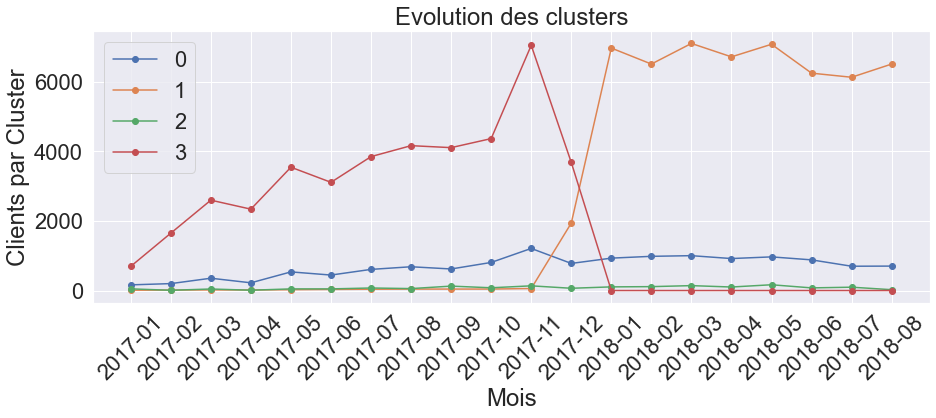

In [126]:
fig = plt.figure(figsize=(15,5))
ax = plt.gca()

for col in df_final_date_per_month.columns:
    if col != 'Month':
        ax.plot(df_final_date_per_month['Month'], df_final_date_per_month[col], marker='o', label=col)

plt.xlabel('Mois')
plt.xticks(rotation=45)
plt.ylabel('Clients par Cluster')
plt.title('Evolution des clusters')
plt.legend()
plt.show()

## Satisfaction Analysis

### Review_score

In [119]:
df_final_date_per_month_reviews = df_final_date.groupby(
    ['Month', 'Kmeans_cluster'])['review_score'].mean().unstack().fillna(0).reset_index()

In [120]:
df_final_date_per_month_reviews

Kmeans_cluster    Month         0         1         2         3
0               2017-01  3.953885  4.888889  4.854167  4.208698
1               2017-02  4.191912  4.230769  4.142857  4.211613
2               2017-03  3.855630  4.444444  3.340909  4.180178
3               2017-04  4.070909  4.406250  2.222222  4.114212
4               2017-05  3.935638  4.416667  4.279433  4.236865
5               2017-06  4.134113  4.516129  4.170213  4.195793
6               2017-07  3.898144  4.608108  2.011021  4.247188
7               2017-08  3.962067  4.280488  4.642857  4.341211
8               2017-09  3.764519  4.559524  3.736783  4.273039
9               2017-10  3.716801  4.464286  3.089594  4.210078
10              2017-11  3.462428  4.258621  3.687542  3.989864
11              2017-12  3.692022  4.227131  2.424176  4.005059
12              2018-01  3.414194  4.134032  2.145170  0.000000
13              2018-02  3.330095  3.891335  3.127179  0.000000
14              2018-03  3.473684  3.800978  3.080378  0.000000
15              2018-04  3.568761  4.194224  3.807756  0.000000
16              2018-05  3.917585  4.219938  3.393287  0.000000
17              2018-06  3.876792  4.279124  2.299123  0.000000
18              2018-07  4.131730  4.313217  3.905263  0.000000
19              2018-08  3.771755  4.331050  3.640152  0.000000

In [121]:
df_final_date_per_month_reviews['Month'] = df_final_date_per_month_reviews['Month'].astype('str')

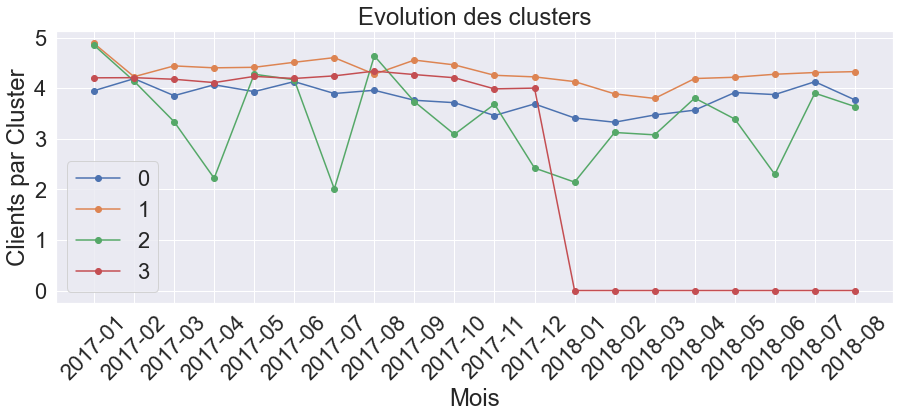

In [122]:
fig = plt.figure(figsize=(15,5))
ax = plt.gca()

for col in df_final_date_per_month_reviews.columns:
    if col != 'Month':
        ax.plot(df_final_date_per_month_reviews['Month'], df_final_date_per_month_reviews[col], marker='o', label=col)

plt.xlabel('Mois')
plt.xticks(rotation=45)
plt.ylabel('Clients des reviews')
plt.title('Evolution des clusters')
plt.legend()
plt.show()

### Longueur comment

In [127]:
df_final_date_per_month_longueur_comment_message = df_final_date.groupby(
    ['Month', 'Kmeans_cluster'])['longueur_comment_message'].mean().unstack().fillna(0).reset_index()

In [128]:
df_final_date_per_month_longueur_comment_message

Kmeans_cluster    Month          0          1           2          3
0               2017-01  40.456544  22.722222    1.000000  31.514820
1               2017-02  34.255444  47.423077   41.428571  28.347671
2               2017-03  35.648094  30.833333   13.545455  29.213344
3               2017-04  22.613182  37.718750  105.711111  27.489266
4               2017-05  25.520563  28.020833   25.092199  28.054956
5               2017-06  27.982240  22.661290   21.992908  27.632686
6               2017-07  32.228335  22.081081   59.154421  27.366074
7               2017-08  32.990992  27.573171    6.404762  25.825175
8               2017-09  39.144461  26.821429   31.409449  27.177206
9               2017-10  38.641692  17.678571   24.866897  28.200874
10              2017-11  40.145738  21.784483   17.479192  28.194433
11              2017-12  39.457891  28.207121   14.630769  29.740361
12              2018-01  45.104375  28.834249   73.582313   0.000000
13              2018-02  45.206686  32.116389   26.466936   0.000000
14              2018-03  44.490125  30.974281   50.704492   0.000000
15              2018-04  46.951321  28.134446   42.844884   0.000000
16              2018-05  37.135367  27.193420   36.434596   0.000000
17              2018-06  39.171563  27.567394   50.739724   0.000000
18              2018-07  33.280196  26.322073   49.705263   0.000000
19              2018-08  33.466476  24.988377   24.950758   0.000000

In [129]:
df_final_date_per_month_longueur_comment_message['Month'] = df_final_date_per_month_longueur_comment_message['Month'].astype(
    'str')

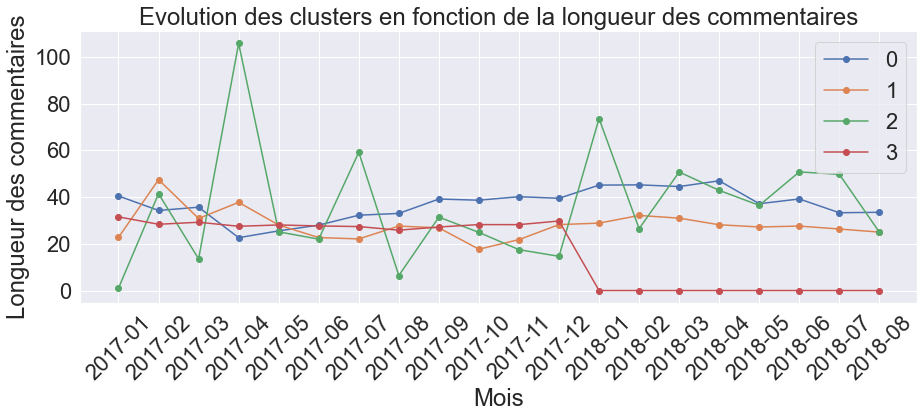

In [131]:
fig = plt.figure(figsize=(15, 5))
ax = plt.gca()

for col in df_final_date_per_month_longueur_comment_message.columns:
    if col != 'Month':
        ax.plot(df_final_date_per_month_longueur_comment_message['Month'],
                df_final_date_per_month_longueur_comment_message[col], marker='o', label=col)

plt.xlabel('Mois')
plt.xticks(rotation=45)
plt.ylabel('Longueur des commentaires')
plt.title('Evolution des clusters en fonction de la longueur des commentaires')
plt.legend()
plt.show()

### Delais de livraison estimé

In [132]:
df_final_date_per_month_delay_delivered = df_final_date.groupby(
    ['Month', 'Kmeans_cluster'])['temps_livraison_estime'].mean().unstack().fillna(0).reset_index()

In [133]:
df_final_date_per_month_delay_delivered

Kmeans_cluster    Month             0             1             2  \
0               2017-01  3.543364e+06  2.643402e+06  3.691191e+06   
1               2017-02  2.865330e+06  2.499777e+06  1.994245e+06   
2               2017-03  2.171777e+06  2.289935e+06  2.063448e+06   
3               2017-04  2.349627e+06  2.386162e+06  2.266987e+06   
4               2017-05  2.034253e+06  2.061983e+06  2.086141e+06   
5               2017-06  2.056825e+06  2.145469e+06  1.804683e+06   
6               2017-07  1.973051e+06  2.051802e+06  2.016859e+06   
7               2017-08  2.024893e+06  2.071453e+06  2.161420e+06   
8               2017-09  1.970475e+06  1.820642e+06  2.186520e+06   
9               2017-10  1.986616e+06  2.043907e+06  1.728145e+06   
10              2017-11  1.911128e+06  1.920729e+06  2.157607e+06   
11              2017-12  2.284291e+06  2.423285e+06  2.179825e+06   
12              2018-01  2.352607e+06  2.236767e+06  2.385162e+06   
13              2018-02  2.105190e+06  2.091004e+06  1.911375e+06   
14              2018-03  1.980481e+06  1.878302e+06  2.121925e+06   
15              2018-04  2.022512e+06  1.991517e+06  2.159448e+06   
16              2018-05  2.003880e+06  1.932058e+06  2.144595e+06   
17              2018-06  2.333275e+06  2.368605e+06  2.402702e+06   
18              2018-07  1.711646e+06  1.672081e+06  2.131562e+06   
19              2018-08  1.557884e+06  1.305322e+06  1.792287e+06   

Kmeans_cluster             3  
0               3.349673e+06  
1               2.741702e+06  
2               2.115098e+06  
3               2.316577e+06  
4               2.062014e+06  
5               2.048130e+06  
6               1.998725e+06  
7               1.984597e+06  
8               1.898727e+06  
9               1.956781e+06  
10              1.906617e+06  
11              2.305468e+06  
12              0.000000e+00  
13              0.000000e+00  
14              0.000000e+00  
15              0.000000e+00  
16              0.000000e+00  
17              0.000000e+00  
18              0.000000e+00  
19              0.000000e+00

In [134]:
df_final_date_per_month_delay_delivered['Month'] = df_final_date_per_month_delay_delivered['Month'].astype(
    'str')

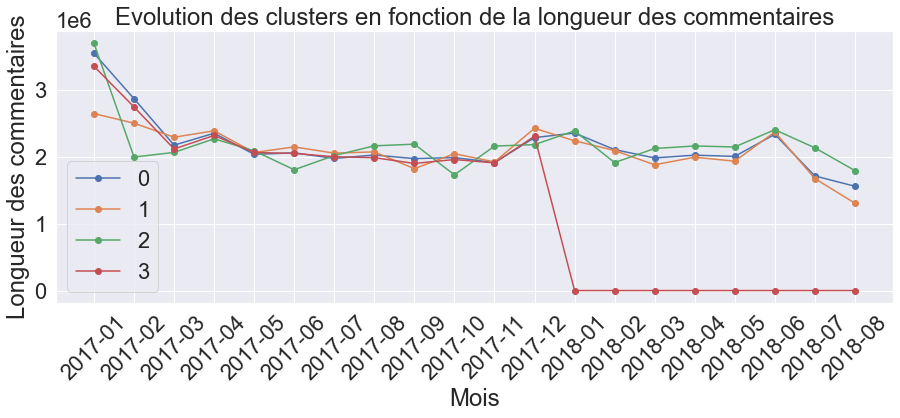

In [135]:
fig = plt.figure(figsize=(15, 5))
ax = plt.gca()

for col in df_final_date_per_month_delay_delivered.columns:
    if col != 'Month':
        ax.plot(df_final_date_per_month_delay_delivered['Month'],
                df_final_date_per_month_delay_delivered[col], marker='o', label=col)

plt.xlabel('Mois')
plt.xticks(rotation=45)
plt.ylabel('Longueur des commentaires')
plt.title('Evolution des clusters en fonction de la longueur des commentaires')
plt.legend()
plt.show()

### Expérience client
a partir du moment ou il y a l'achat jusqu'à la livraison, l'idée ici pour l'entreprise est d'avoir une expérience courte, voulait induire un site fonctionnel, intuitif et des temps de livraison rapide

In [136]:
df_final_date_per_month_experience = df_final_date.groupby(
    ['Month', 'Kmeans_cluster'])['experience_client'].mean().unstack().fillna(0).reset_index()

In [137]:
df_final_date_per_month_experience

Kmeans_cluster    Month             0             1             2  \
0               2017-01  9.871759e+05  8.579411e+05  1.342254e+06   
1               2017-02  1.040470e+06  1.070607e+06  1.142027e+06   
2               2017-03  1.130680e+06  9.836069e+05  1.163101e+06   
3               2017-04  1.122906e+06  1.219335e+06  1.316624e+06   
4               2017-05  1.035719e+06  1.051870e+06  1.059287e+06   
5               2017-06  1.122507e+06  1.028201e+06  1.215372e+06   
6               2017-07  8.622459e+05  8.864293e+05  1.390803e+06   
7               2017-08  8.627199e+05  1.017596e+06  1.042835e+06   
8               2017-09  1.064159e+06  9.227686e+05  1.343545e+06   
9               2017-10  9.659057e+05  1.104492e+06  9.734610e+05   
10              2017-11  1.144931e+06  1.151999e+06  1.273836e+06   
11              2017-12  1.207030e+06  1.255716e+06  1.474674e+06   
12              2018-01  1.267508e+06  1.192047e+06  1.304244e+06   
13              2018-02  1.424322e+06  1.446785e+06  1.402883e+06   
14              2018-03  1.214257e+06  1.408004e+06  1.387839e+06   
15              2018-04  8.882511e+05  9.947348e+05  1.285050e+06   
16              2018-05  9.288717e+05  9.820001e+05  1.112095e+06   
17              2018-06  7.385077e+05  7.966371e+05  1.025794e+06   
18              2018-07  7.173609e+05  7.704778e+05  1.050946e+06   
19              2018-08  6.484685e+05  6.632168e+05  6.107088e+05   

Kmeans_cluster             3  
0               1.088324e+06  
1               1.115269e+06  
2               1.118952e+06  
3               1.269743e+06  
4               9.835153e+05  
5               1.044867e+06  
6               1.008454e+06  
7               9.490453e+05  
8               1.012244e+06  
9               1.010503e+06  
10              1.279888e+06  
11              1.377832e+06  
12              0.000000e+00  
13              0.000000e+00  
14              0.000000e+00  
15              0.000000e+00  
16              0.000000e+00  
17              0.000000e+00  
18              0.000000e+00  
19              0.000000e+00

In [138]:
df_final_date_per_month_experience['Month'] = df_final_date_per_month_experience['Month'].astype(
    'str')

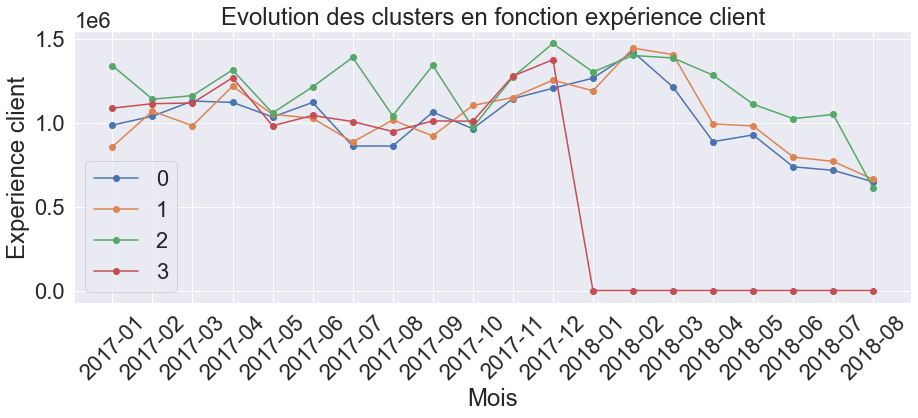

In [139]:
fig = plt.figure(figsize=(15, 5))
ax = plt.gca()

for col in df_final_date_per_month_experience.columns:
    if col != 'Month':
        ax.plot(df_final_date_per_month_experience['Month'],
                df_final_date_per_month_experience[col], marker='o', label=col)

plt.xlabel('Mois')
plt.xticks(rotation=45)
plt.ylabel('Experience client')
plt.title('Evolution des clusters en fonction expérience client')
plt.legend()
plt.show()

# Analyse en Composante Principale (ACP)

In [96]:
df_final

recency  frequency  monetary_value  Kmeans_cluster  bed_bath_table  \
0          234        1.0          141.90               1               1   
1          237        1.0           27.19               1               0   
2          660        1.0           86.22               3               0   
3          444        1.0           43.62               3               0   
4          411        1.0          196.89               3               0   
...        ...        ...             ...             ...             ...   
91069      570        2.0         4134.84               0               0   
91070      385        1.0           84.58               3               0   
91071      691        1.0          112.46               3               0   
91072      242        1.0          133.69               1               0   
91073      606        1.0           71.56               3               0   

       health_beauty  sports_leisure  furniture_decor  computers_accessories  \
0                  0               0                0                      0   
1                  1               0                0                      0   
2                  0               0                0                      0   
3                  0               0                0                      0   
4                  0               0                0                      0   
...              ...             ...              ...                    ...   
91069              2               0                0                      0   
91070              0               0                0                      0   
91071              0               0                0                      0   
91072              0               0                0                      0   
91073              0               0                0                      0   

       housewares  ...  fashion_shoes  industry_commerce_and_business  \
0               0  ...              0                               0   
1               0  ...              0                               0   
2               0  ...              0                               0   
3               0  ...              0                               0   
4               0  ...              0                               0   
...           ...  ...            ...                             ...   
91069           0  ...              0                               0   
91070           0  ...              0                               0   
91071           0  ...              0                               0   
91072           0  ...              0                               0   
91073           0  ...              0                               0   

       books_technical  temps_session  experience_client  \
0                    0          891.0           553930.0   
1                    0        26057.0           283875.0   
2                    0            0.0          2223224.0   
3                    0         1176.0          1731204.0   
4                    0         1270.0          1135394.0   
...                ...            ...                ...   
91069                0          880.0          2377284.0   
91070                0          504.0          2600424.0   
91071                0          808.0          1284948.0   
91072                0         2466.0          1024605.0   
91073                0        68188.0           652503.0   

       temps_livraison_estime  review_score  temps_de_reponse  \
0                    910122.0           5.0          4.572778   
1                    624856.0           4.0          0.937095   
2                   2343297.0           3.0          1.055370   
3                   2689843.0           4.0          1.012396   
4                   1741988.0           5.0          4.937211   
...                       ...           ...               ...   
91069               4675484.0           5.0          4.472280   
910

In [ ]:
# definir X
X = df_acp.select_dtypes('float')

In [ ]:
# Initialize
model = pca(n_components=6, normalize=True)

In [ ]:
# Fit transform
out = model.fit_transform(X)

## Diagramme éboulis des valeurs propres


In [ ]:
# Scree plot
fig, ax = model.plot(figsize=(16, 10))

## Cercle de corrélation

In [ ]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:  # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7, 6))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1, :]), max(
                    pcs[d1, :]), min(pcs[d2, :]), max(pcs[d2, :])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                           pcs[d1, :], pcs[d2, :],
                           angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(LineCollection(
                    lines, axes=ax, alpha=.1, color='black'))

            # affichage des noms des variables
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize='14', ha='center',
                                 va='center', rotation=label_rotation, color="blue", alpha=0.5)

            # affichage du cercle
            circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('PC{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('PC{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title("Cercle des corrélations (PC{} et PC{})".format(d1+1, d2+1))
            plt.show(block=False)

In [ ]:
n_comp = 4
pcs = pca.components_
fig = plt.figure(figsize=(16, 16))
display_circles(pcs, n_comp, pca, [
                (0, 1), (2, 3), (4, 5)], labels=np.array(features))